# Table of Contents
 <p><div class="lev1"><a href="#Initialize-Environment"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev1"><a href="#Subgraph-of-Brain-Systems"><span class="toc-item-num">2&nbsp;&nbsp;</span>Subgraph of Brain Systems</a></div><div class="lev2"><a href="#Focal-vs-Distributed-Subgraphs"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Focal vs Distributed Subgraphs</a></div><div class="lev2"><a href="#Formulate-ROI-Dict"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Formulate ROI Dict</a></div><div class="lev2"><a href="#Convert-ROI-Subgraphs-to-Brain-System-Subgraphs"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert ROI Subgraphs to Brain System Subgraphs</a></div><div class="lev2"><a href="#Between-Task-Subgraph-Contrast"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Between-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Within-Task-Subgraph-Contrast"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Within-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Subgraph-Expression-vs-Behavior"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Subgraph Expression vs Behavior</a></div><div class="lev3"><a href="#Load-Behavioral-Data"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Load Behavioral Data</a></div><div class="lev3"><a href="#Predicting-High-Demand-Condition-RT-(Hi)"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Predicting High Demand Condition RT (Hi)</a></div><div class="lev3"><a href="#Predicting-High-Demand-Condition-RT-(Hi-Lo)"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>Predicting High Demand Condition RT (Hi-Lo)</a></div><div class="lev3"><a href="#Predicting-High-Demand-Condition-Accuracy-(Hi)"><span class="toc-item-num">2.6.4&nbsp;&nbsp;</span>Predicting High Demand Condition Accuracy (Hi)</a></div><div class="lev3"><a href="#Predicting-High-Demand-Condition-Accuracy-(Hi-Lo)"><span class="toc-item-num">2.6.5&nbsp;&nbsp;</span>Predicting High Demand Condition Accuracy (Hi-Lo)</a></div>

# Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis_Notebooks/')

path_Remotes = '/data/jag/akhambhati/hoth_research'
path_CoreData = path_Remotes + '/CORE.fMRI_cogcontrol.medaglia'
path_RsrchData = path_Remotes + '/RSRCH.NMF_CogControl'
path_InpData = path_RsrchData + '/e02b-FuncSubg'
path_ExpData = path_RsrchData + '/e04b-FuncSubg_Dynamics'

for path in [path_CoreData, path_RsrchData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Subgraph of Brain Systems

In [2]:
df_nmf = np.load('{}/NMF_Consensus.npz'.format(path_InpData), mmap_mode='r')
fac_subnet = df_nmf['fac_subnet']
fac_coef = df_nmf['fac_coef']
n_fac = fac_subnet.shape[0]
n_conn = fac_subnet.shape[1]
n_obs = fac_coef.shape[1]

## Focal vs Distributed Subgraphs

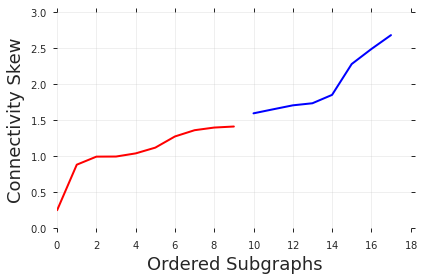

In [13]:
real_subg_skew = np.array([stats.skew(subg) for subg in fac_subnet])
real_ix = np.argsort(real_subg_skew)

n_null = 10000
rnd_coef = np.random.uniform(size=(n_null, n_fac))
rnd_subnet = np.dot(rnd_coef, fac_subnet)

rnd_subg_skew = np.array([stats.skew(subg) for subg in rnd_subnet])
rnd_ix = np.argsort(rnd_subg_skew)

low_ix = np.flatnonzero(real_subg_skew[real_ix] < np.min(rnd_subg_skew))
mid_ix = np.flatnonzero((real_subg_skew[real_ix] >= np.min(rnd_subg_skew)) &
                        (real_subg_skew[real_ix] <= np.max(rnd_subg_skew)))
high_ix = np.flatnonzero(real_subg_skew[real_ix] > np.max(rnd_subg_skew))

%matplotlib inline
plt.figure()
ax = plt.subplot(111)
ax.plot(low_ix, real_subg_skew[real_ix][low_ix], color='b')
ax.plot(mid_ix, real_subg_skew[real_ix][mid_ix], color='r')
ax.plot(high_ix, real_subg_skew[real_ix][high_ix], color='b')
ax.set_xlabel('Ordered Subgraphs')
ax.set_ylabel('Connectivity Skew')
ax.set_xlim([0, n_fac])

high_ix = np.unique(np.concatenate([high_ix, low_ix, mid_ix]))

## Formulate ROI Dict

In [14]:
df_parcel = pd.read_csv('{}/LausanneScale125.csv'.format(path_CoreData))

all_roi_names = []

roi_dict = {}
for lbl_id, lbl_roi, lbl_hemi in zip(df_parcel.Label_ID, df_parcel.ROI, df_parcel.Hemisphere):
    roi_name = '{}_{}'.format(lbl_hemi, lbl_roi.split('_')[0])
    #roi_name = lbl_roi.split('_')[0]
    
    if roi_name not in all_roi_names:
        all_roi_names.append(roi_name)

    try:
        roi_dict[roi_name]
    except KeyError:
        roi_dict[roi_name] = []

    roi_dict[roi_name].append(lbl_id-1)
n_roi = len(all_roi_names)
n_conn_roi = int(n_roi*(n_roi-1)*0.5)

## Convert ROI Subgraphs to Brain System Subgraphs

In [15]:
bs_fac_subnet = np.zeros((n_fac, n_conn_roi))
for fac_i, subg in enumerate(fac_subnet):
    adj = conv_cfg_vec_to_adj_matr(subg)
    
    tmp_subnet = np.zeros((1, n_roi, n_roi))
    for ij_ii, ij_roi in enumerate(all_roi_names):
        for ik_ii, ik_roi in enumerate(all_roi_names):
            
            mean_conn = adj[roi_dict[ij_roi], :][:, roi_dict[ik_roi]].mean()
            tmp_subnet[0, ij_ii, ik_ii] = mean_conn
    bs_fac_subnet[fac_i, :] = conv_adj_matr_to_cfg_matr(tmp_subnet)[0, :]

## Between-Task Subgraph Contrast

****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

    Pos-Stroop-Navon: ts: -3.369e+00 pval: 2.284e-03 sig: *
    Neg-Stroop-Navon: ts: 1.691e+00 pval: 1.024e-01 sig: 


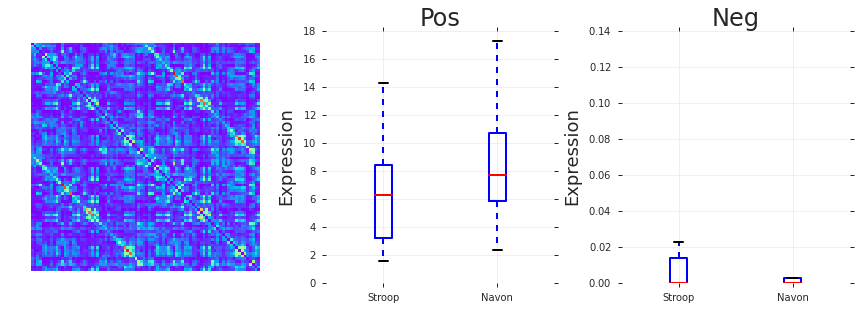





****************************** Subgraph 15 ******************************
    LH_parstriangularis
    RH_rostralmiddlefrontal
    RH_parsopercularis
    RH_putamen
    LH_parsopercularis
    RH_parstriangularis

    Pos-Stroop-Navon: ts: -6.214e+00 pval: 1.208e-06 sig: *
    Neg-Stroop-Navon: ts: 4.282e+00 pval: 2.091e-04 sig: *


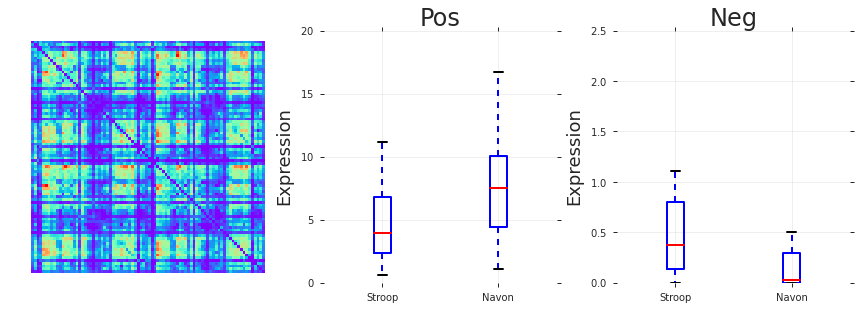





****************************** Subgraph 17 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Pos-Stroop-Navon: ts: 3.660e+00 pval: 1.081e-03 sig: *
    Neg-Stroop-Navon: ts: -1.040e+00 pval: 3.077e-01 sig: 


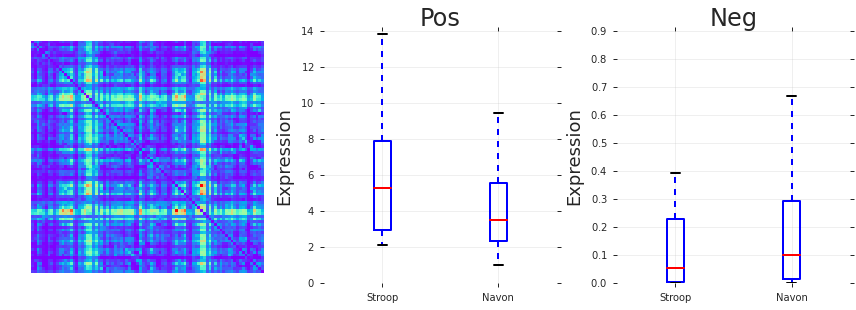





****************************** Subgraph 18 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

    Pos-Stroop-Navon: ts: -6.613e+00 pval: 4.276e-07 sig: *
    Neg-Stroop-Navon: ts: 2.638e+00 pval: 1.366e-02 sig: 


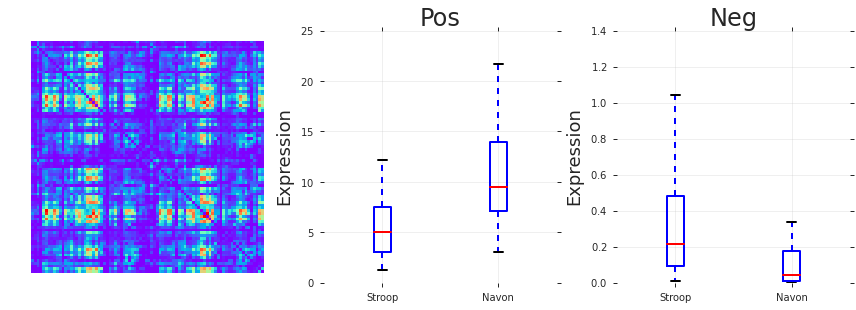

In [16]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Pos': {'Stroop': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                   'Navon': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon']},
           'Neg': {'Stroop': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop'],
                   'Navon': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Pos', 'Neg']
key_order = ['Stroop', 'Navon']

#sel_fac_ix = xrange(n_fac)
sel_fac_ix = np.sort(real_ix[high_ix])

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():
        subplot_dict = {'title': grp,
                        'xlabel': [],
                        'distrib': [],
                        'stats': []}
        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)

            mean_subj_coef = 0.5*(np.mean(subj_hi, axis=1) + np.mean(subj_lo, axis=1))
            
            subplot_dict['xlabel'].append(key)
            subplot_dict['distrib'].append(mean_subj_coef)
        
        for key_pair in [[0,1]]:
            ts, pv = stats.ttest_rel(subplot_dict['distrib'][key_pair[0]],
                                     subplot_dict['distrib'][key_pair[1]])      
            subplot_dict['stats'].append({'name': '{}-{}'.format(subplot_dict['xlabel'][key_pair[0]],
                                                                 subplot_dict['xlabel'][key_pair[1]]),
                                          'tstat': ts,
                                          'pval': pv,
                                          'sig': ''})
            
        plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_stat['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']
                    for fac_stat in fac_subp['stats']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
sel_fac_between_sig = []
for fac_ii, fac_plot in enumerate(plot_list):
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        for fac_stat in fac_subp['stats']:
            if fac_stat['pval'] < adj_alpha:
                fac_stat['sig'] = '*'
                sel_fac_between_sig.append(fac_ii)
            pval_list.append(fac_stat['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)
sel_fac_between_sig = np.unique(sel_fac_between_sig)

# Plot each result
for fac_ix in sel_fac_between_sig:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2, 3]
    
    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        ax.boxplot(fac_subp['distrib'])
        ax.set_xticklabels(fac_subp['xlabel'])
        ax.set_ylabel('Expression')
        ax.set_title(fac_subp['title'])
        #ax.yaxis.set_ticks_position('left')
        #ax.xaxis.set_ticks_position('bottom')


        for fac_stat in fac_subp['stats']:
            print('    %s-%s: ts: %0.3e pval: %0.3e sig: %s' % 
                  (fac_subp['title'], fac_stat['name'],
                   fac_stat['tstat'], fac_stat['pval'],
                   fac_stat['sig']))        
            
    plt.show()
    print('\n\n\n')

## Within-Task Subgraph Contrast

****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

      Stroop_Pos: Rs-Lo: ts: -1.154e+00 pval: 2.588e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -2.287e+00 pval: 3.029e-02 sig: 
      Stroop_Pos: Lo-Hi: ts: -1.760e+00 pval: 8.966e-02 sig: 

       Navon_Pos: Rs-Lo: ts: -1.665e+00 pval: 1.075e-01 sig: 
       Navon_Pos: Rs-Hi: ts: -3.964e+00 pval: 4.873e-04 sig: *
       Navon_Pos: Lo-Hi: ts: -2.161e+00 pval: 3.977e-02 sig: 

      Stroop_Neg: Rs-Lo: ts: 4.930e-01 pval: 6.260e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 1.357e+00 pval: 1.861e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 1.543e+00 pval: 1.345e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 2.606e+00 pval: 1.472e-02 sig: 
       Navon_Neg: Rs-Hi: ts: 2.794e+00 pval: 9.466e-03 sig: 
       Navon_Neg: Lo-Hi: ts: 4.478e-01 pval: 6.579e-01 sig: 



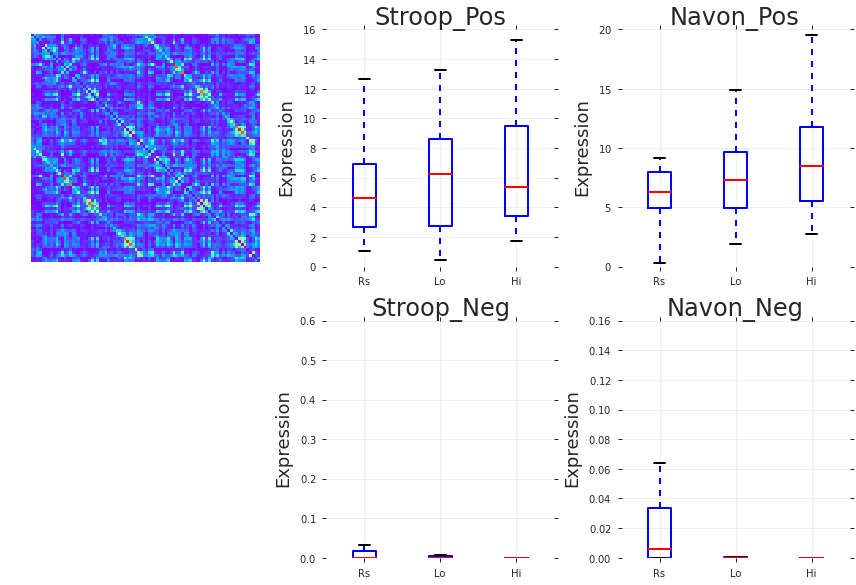





****************************** Subgraph 2 ******************************
    RH_accumbensarea
    LH_accumbensarea
    RH_lateralorbitofrontal
    RH_medialorbitofrontal
    LH_lateralorbitofrontal
    RH_frontalpole

      Stroop_Pos: Rs-Lo: ts: -3.058e-01 pval: 7.621e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -1.561e-01 pval: 8.772e-01 sig: 
      Stroop_Pos: Lo-Hi: ts: 1.605e-01 pval: 8.737e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -8.995e-01 pval: 3.764e-01 sig: 
       Navon_Pos: Rs-Hi: ts: -1.181e+00 pval: 2.480e-01 sig: 
       Navon_Pos: Lo-Hi: ts: -1.385e-01 pval: 8.909e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: 3.441e+00 pval: 1.899e-03 sig: *
      Stroop_Neg: Rs-Hi: ts: 3.393e+00 pval: 2.146e-03 sig: *
      Stroop_Neg: Lo-Hi: ts: -5.453e-01 pval: 5.900e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 3.819e+00 pval: 7.129e-04 sig: *
       Navon_Neg: Rs-Hi: ts: 2.148e+00 pval: 4.088e-02 sig: 
       Navon_Neg: Lo-Hi: ts: -8.591e-01 pval: 3.978e-01 sig: 



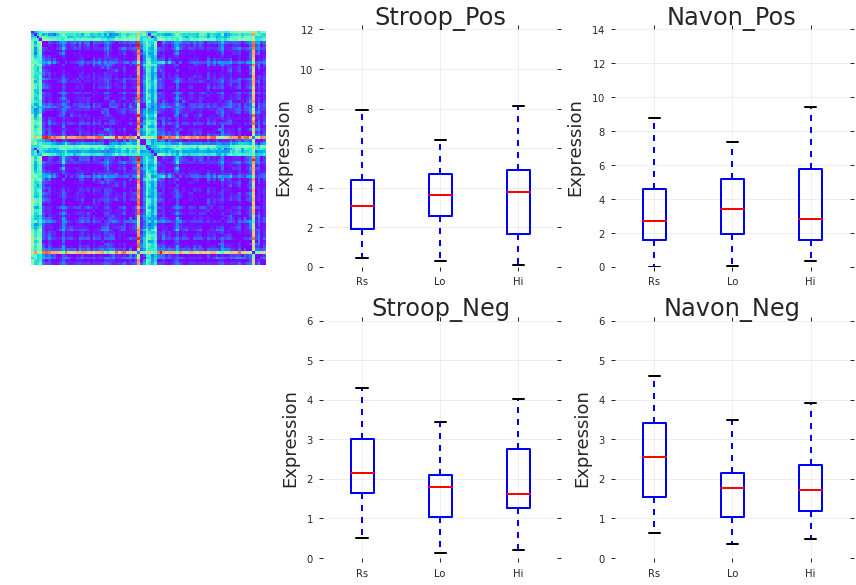





****************************** Subgraph 4 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

      Stroop_Pos: Rs-Lo: ts: 1.417e+00 pval: 1.678e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: 8.787e-01 pval: 3.873e-01 sig: 
      Stroop_Pos: Lo-Hi: ts: -7.160e-01 pval: 4.801e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -3.172e-01 pval: 7.535e-01 sig: 
       Navon_Pos: Rs-Hi: ts: 8.518e-01 pval: 4.018e-01 sig: 
       Navon_Pos: Lo-Hi: ts: 1.133e+00 pval: 2.673e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -2.631e+00 pval: 1.390e-02 sig: 
      Stroop_Neg: Rs-Hi: ts: -2.560e+00 pval: 1.639e-02 sig: 
      Stroop_Neg: Lo-Hi: ts: 3.627e-01 pval: 7.197e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -2.160e+00 pval: 3.984e-02 sig: 
       Navon_Neg: Rs-Hi: ts: -3.369e+00 pval: 2.283e-03 sig: *
       Navon_Neg: Lo-Hi: ts: -1.499e+00 pval: 1.456e-01 sig: 



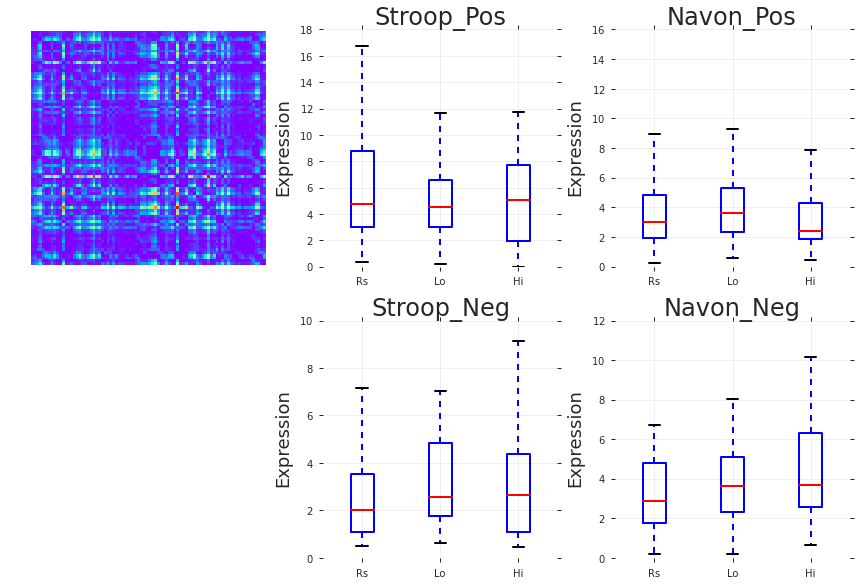





****************************** Subgraph 7 ******************************
    RH_isthmuscingulate
    LH_isthmuscingulate
    RH_precuneus
    RH_pericalcarine
    LH_pericalcarine
    LH_paracentral

      Stroop_Pos: Rs-Lo: ts: 4.020e+00 pval: 4.193e-04 sig: *
      Stroop_Pos: Rs-Hi: ts: 3.557e+00 pval: 1.409e-03 sig: *
      Stroop_Pos: Lo-Hi: ts: 4.702e-02 pval: 9.628e-01 sig: 

       Navon_Pos: Rs-Lo: ts: 3.579e+00 pval: 1.331e-03 sig: *
       Navon_Pos: Rs-Hi: ts: 3.250e+00 pval: 3.088e-03 sig: *
       Navon_Pos: Lo-Hi: ts: -5.082e-01 pval: 6.155e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -1.852e+00 pval: 7.497e-02 sig: 
      Stroop_Neg: Rs-Hi: ts: -2.373e+00 pval: 2.503e-02 sig: 
      Stroop_Neg: Lo-Hi: ts: 3.516e-02 pval: 9.722e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -3.216e-01 pval: 7.503e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -1.980e+00 pval: 5.804e-02 sig: 
       Navon_Neg: Lo-Hi: ts: -1.668e+00 pval: 1.069e-01 sig: 



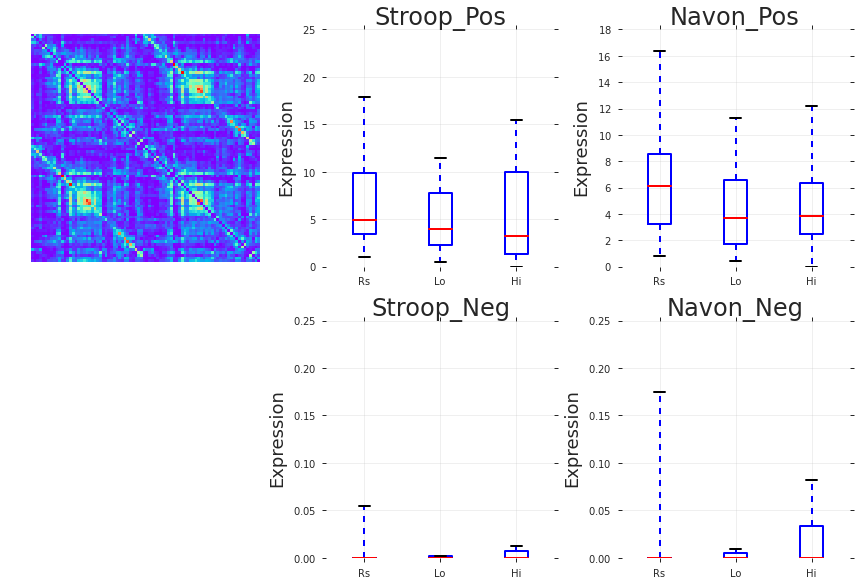





****************************** Subgraph 8 ******************************
    LH_cuneus
    RH_insula
    RH_precentral
    LH_insula
    RH_parsopercularis
    RH_transversetemporal

      Stroop_Pos: Rs-Lo: ts: 1.686e+00 pval: 1.033e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: 9.855e-01 pval: 3.331e-01 sig: 
      Stroop_Pos: Lo-Hi: ts: -6.133e-01 pval: 5.448e-01 sig: 

       Navon_Pos: Rs-Lo: ts: 1.211e+00 pval: 2.363e-01 sig: 
       Navon_Pos: Rs-Hi: ts: 4.987e+00 pval: 3.150e-05 sig: *
       Navon_Pos: Lo-Hi: ts: 4.242e+00 pval: 2.329e-04 sig: *

      Stroop_Neg: Rs-Lo: ts: -7.698e-01 pval: 4.481e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 1.514e-01 pval: 8.808e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 9.148e-01 pval: 3.684e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 1.026e+00 pval: 3.141e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -1.056e-01 pval: 9.167e-01 sig: 
       Navon_Neg: Lo-Hi: ts: -1.062e+00 pval: 2.978e-01 sig: 



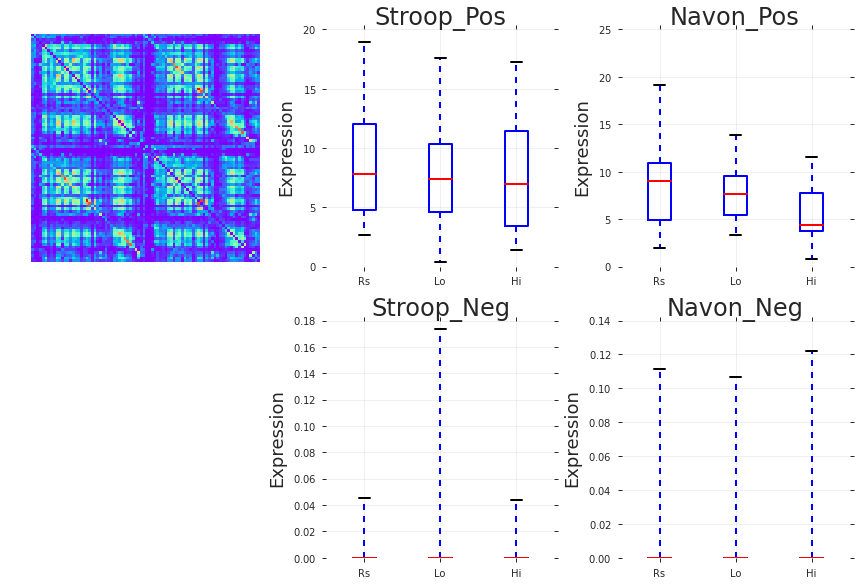





****************************** Subgraph 9 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

      Stroop_Pos: Rs-Lo: ts: -1.063e+00 pval: 2.970e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -1.770e+00 pval: 8.796e-02 sig: 
      Stroop_Pos: Lo-Hi: ts: -1.256e+00 pval: 2.197e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -3.600e+00 pval: 1.262e-03 sig: *
       Navon_Pos: Rs-Hi: ts: -3.034e+00 pval: 5.282e-03 sig: *
       Navon_Pos: Lo-Hi: ts: -9.175e-02 pval: 9.276e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: 5.434e-02 pval: 9.571e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 3.044e-01 pval: 7.631e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 4.031e-01 pval: 6.901e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 9.476e-01 pval: 3.518e-01 sig: 
       Navon_Neg: Rs-Hi: ts: 7.943e-01 pval: 4.340e-01 sig: 
       Navon_Neg: Lo-Hi: ts: 1.514e-02 pval: 9.880e-01 sig: 



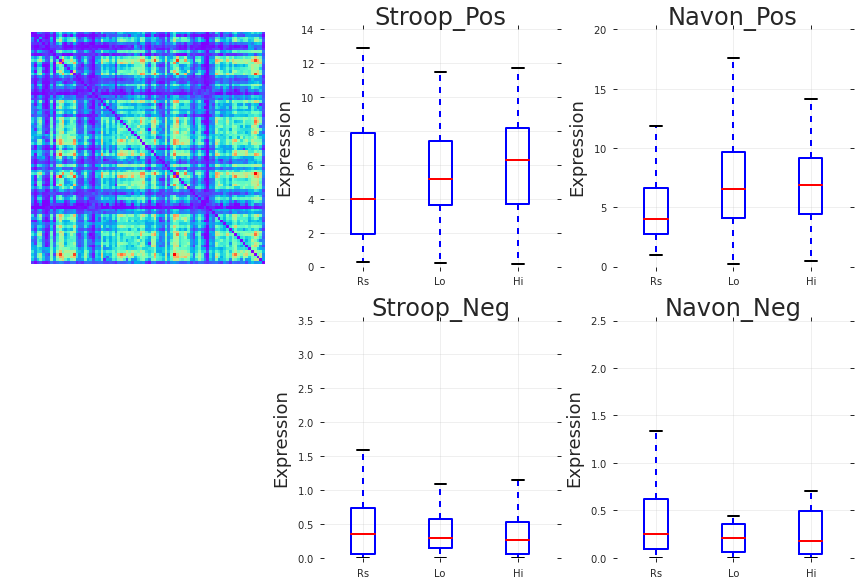





****************************** Subgraph 10 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

      Stroop_Pos: Rs-Lo: ts: -3.081e-01 pval: 7.604e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -2.799e+00 pval: 9.354e-03 sig: 
      Stroop_Pos: Lo-Hi: ts: -3.833e+00 pval: 6.866e-04 sig: *

       Navon_Pos: Rs-Lo: ts: -3.144e+00 pval: 4.030e-03 sig: *
       Navon_Pos: Rs-Hi: ts: -3.420e+00 pval: 2.005e-03 sig: *
       Navon_Pos: Lo-Hi: ts: -9.240e-01 pval: 3.637e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -8.930e-01 pval: 3.798e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 1.707e+00 pval: 9.935e-02 sig: 
      Stroop_Neg: Lo-Hi: ts: 1.782e+00 pval: 8.595e-02 sig: 

       Navon_Neg: Rs-Lo: ts: 1.986e+00 pval: 5.722e-02 sig: 
       Navon_Neg: Rs-Hi: ts: 2.503e+00 pval: 1.865e-02 sig: 
       Navon_Neg: Lo-Hi: ts: 5.369e-01 pval: 5.957e-01 sig: 



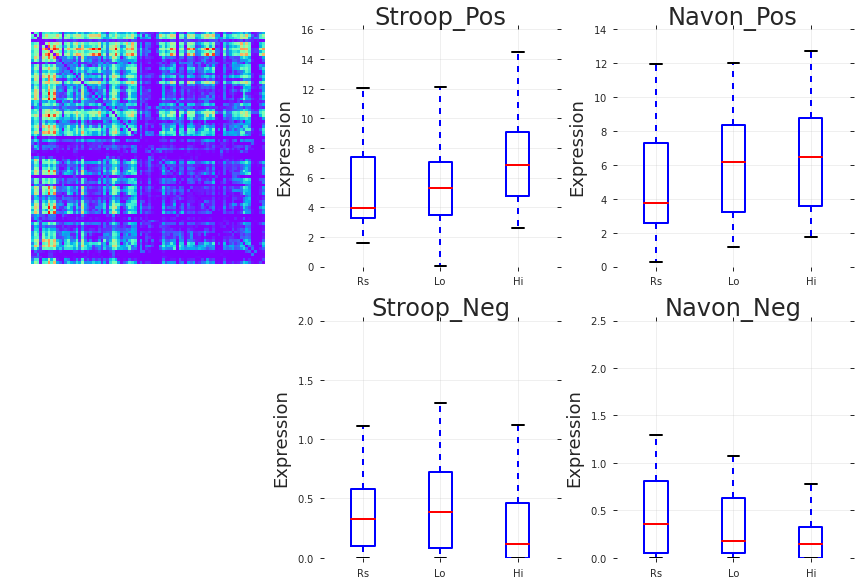





****************************** Subgraph 12 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

      Stroop_Pos: Rs-Lo: ts: 1.211e+00 pval: 2.362e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -2.840e+00 pval: 8.464e-03 sig: 
      Stroop_Pos: Lo-Hi: ts: -4.059e+00 pval: 3.789e-04 sig: *

       Navon_Pos: Rs-Lo: ts: -1.210e+00 pval: 2.368e-01 sig: 
       Navon_Pos: Rs-Hi: ts: -1.582e+00 pval: 1.252e-01 sig: 
       Navon_Pos: Lo-Hi: ts: -7.765e-02 pval: 9.387e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -1.746e+00 pval: 9.221e-02 sig: 
      Stroop_Neg: Rs-Hi: ts: 2.019e+00 pval: 5.349e-02 sig: 
      Stroop_Neg: Lo-Hi: ts: 3.007e+00 pval: 5.651e-03 sig: *

       Navon_Neg: Rs-Lo: ts: -1.275e-01 pval: 8.995e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -2.727e-01 pval: 7.871e-01 sig: 
       Navon_Neg: Lo-Hi: ts: -1.136e-01 pval: 9.104e-01 sig: 



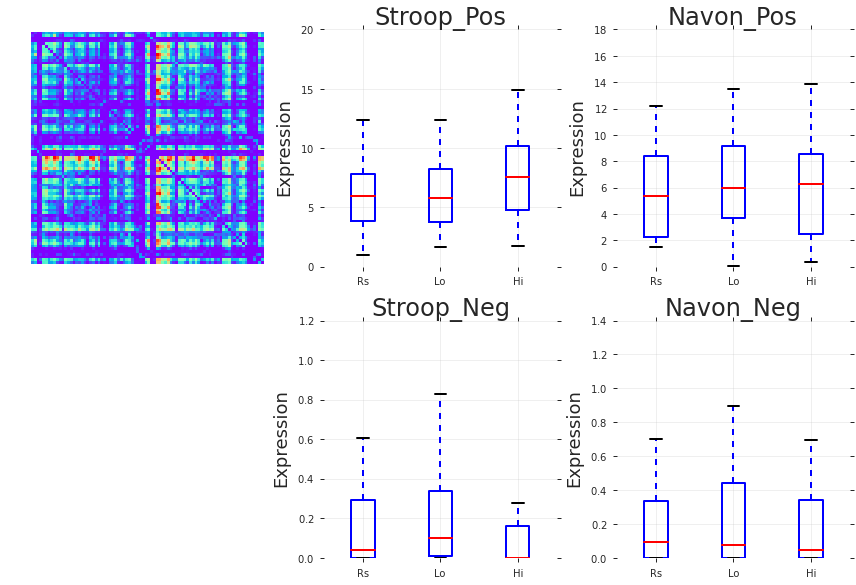





****************************** Subgraph 13 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

      Stroop_Pos: Rs-Lo: ts: -1.843e+00 pval: 7.637e-02 sig: 
      Stroop_Pos: Rs-Hi: ts: -4.216e+00 pval: 2.497e-04 sig: *
      Stroop_Pos: Lo-Hi: ts: -1.448e+00 pval: 1.590e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -1.456e+00 pval: 1.570e-01 sig: 
       Navon_Pos: Rs-Hi: ts: -1.182e+00 pval: 2.475e-01 sig: 
       Navon_Pos: Lo-Hi: ts: 2.435e-01 pval: 8.095e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: 1.566e+00 pval: 1.291e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 2.063e+00 pval: 4.883e-02 sig: 
      Stroop_Neg: Lo-Hi: ts: 6.351e-01 pval: 5.307e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 1.051e+00 pval: 3.025e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -8.072e-01 pval: 4.266e-01 sig: 
       Navon_Neg: Lo-Hi: ts: -1.418e+00 pval: 1.675e-01 sig: 



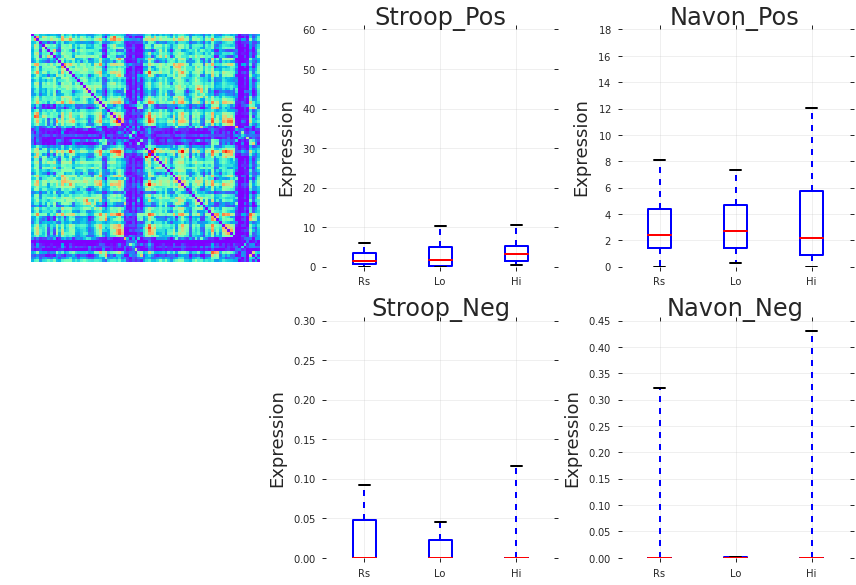





****************************** Subgraph 14 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

      Stroop_Pos: Rs-Lo: ts: -3.354e+00 pval: 2.376e-03 sig: *
      Stroop_Pos: Rs-Hi: ts: -3.717e+00 pval: 9.309e-04 sig: *
      Stroop_Pos: Lo-Hi: ts: -5.233e-01 pval: 6.051e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -5.747e+00 pval: 4.128e-06 sig: *
       Navon_Pos: Rs-Hi: ts: -3.813e+00 pval: 7.239e-04 sig: *
       Navon_Pos: Lo-Hi: ts: 4.689e-01 pval: 6.429e-01 sig: 

      Stroop_Neg: Rs-Lo: ts: -1.245e+00 pval: 2.240e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: -2.034e-02 pval: 9.839e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 1.605e+00 pval: 1.200e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 3.610e-03 pval: 9.971e-01 sig: 
       Navon_Neg: Rs-Hi: ts: 2.510e-01 pval: 8.037e-01 sig: 
       Navon_Neg: Lo-Hi: ts: 3.717e-01 pval: 7.130e-01 sig: 



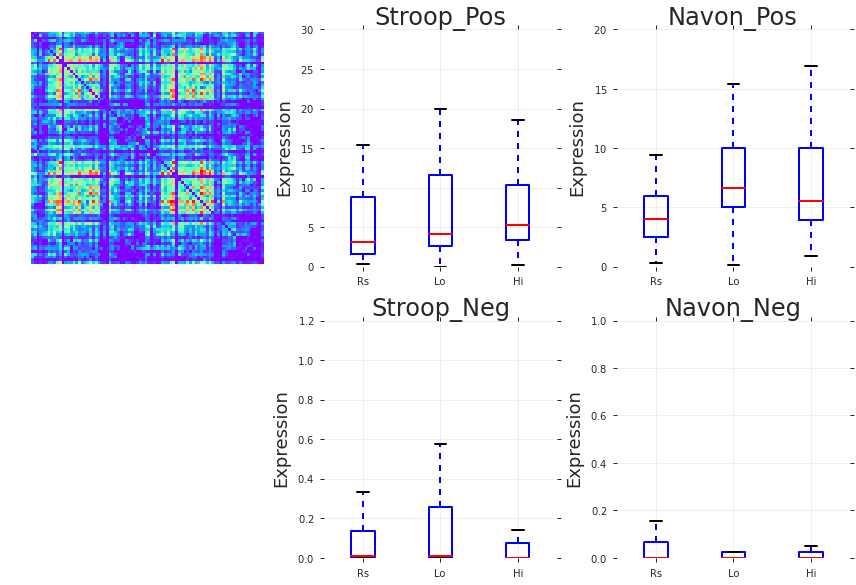





****************************** Subgraph 16 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

      Stroop_Pos: Rs-Lo: ts: 1.450e+00 pval: 1.585e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: 1.432e+00 pval: 1.637e-01 sig: 
      Stroop_Pos: Lo-Hi: ts: -4.179e-01 pval: 6.793e-01 sig: 

       Navon_Pos: Rs-Lo: ts: -1.143e+00 pval: 2.632e-01 sig: 
       Navon_Pos: Rs-Hi: ts: 4.438e-01 pval: 6.607e-01 sig: 
       Navon_Pos: Lo-Hi: ts: 1.853e+00 pval: 7.488e-02 sig: 

      Stroop_Neg: Rs-Lo: ts: -2.451e+00 pval: 2.102e-02 sig: 
      Stroop_Neg: Rs-Hi: ts: -2.723e+00 pval: 1.119e-02 sig: 
      Stroop_Neg: Lo-Hi: ts: -3.412e-03 pval: 9.973e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -1.234e+00 pval: 2.277e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -3.329e+00 pval: 2.525e-03 sig: *
       Navon_Neg: Lo-Hi: ts: -2.546e+00 pval: 1.691e-02 sig: 



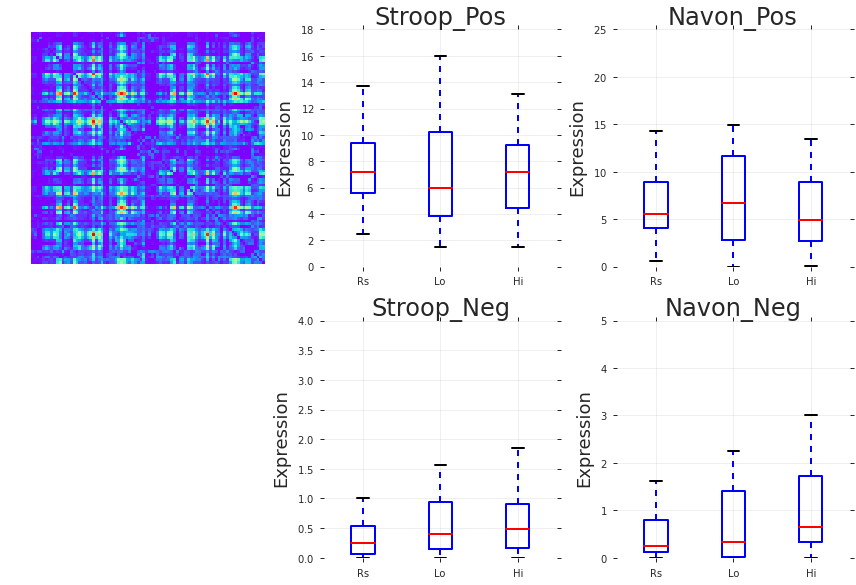





****************************** Subgraph 17 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

      Stroop_Pos: Rs-Lo: ts: -1.067e+00 pval: 2.953e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: 4.270e-03 pval: 9.966e-01 sig: 
      Stroop_Pos: Lo-Hi: ts: 1.152e+00 pval: 2.595e-01 sig: 

       Navon_Pos: Rs-Lo: ts: 3.173e+00 pval: 3.743e-03 sig: *
       Navon_Pos: Rs-Hi: ts: 5.585e+00 pval: 6.357e-06 sig: *
       Navon_Pos: Lo-Hi: ts: 2.861e+00 pval: 8.054e-03 sig: 

      Stroop_Neg: Rs-Lo: ts: 1.608e+00 pval: 1.195e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 8.621e-01 pval: 3.962e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: -5.836e-01 pval: 5.643e-01 sig: 

       Navon_Neg: Rs-Lo: ts: -6.837e-01 pval: 5.000e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -2.947e+00 pval: 6.543e-03 sig: *
       Navon_Neg: Lo-Hi: ts: -2.138e+00 pval: 4.169e-02 sig: 



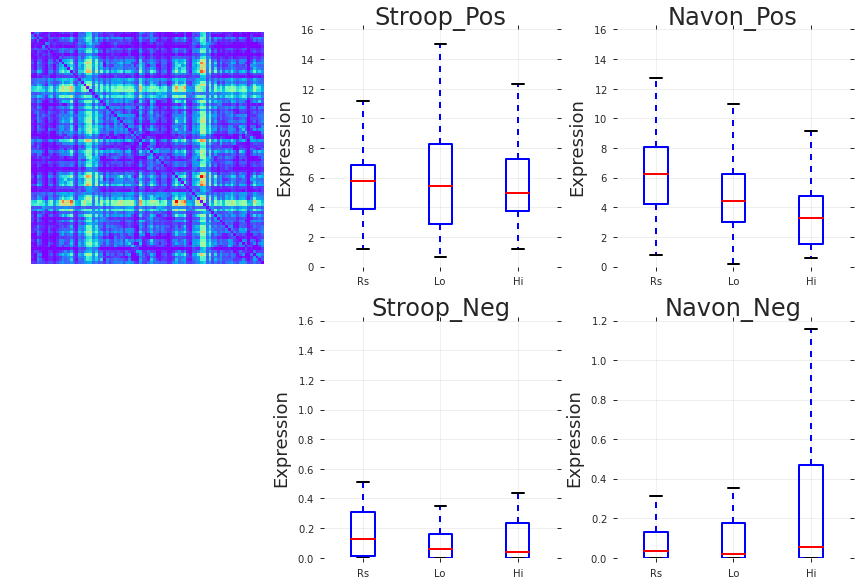





****************************** Subgraph 18 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

      Stroop_Pos: Rs-Lo: ts: -9.952e-01 pval: 3.285e-01 sig: 
      Stroop_Pos: Rs-Hi: ts: -2.123e+00 pval: 4.309e-02 sig: 
      Stroop_Pos: Lo-Hi: ts: -1.814e+00 pval: 8.081e-02 sig: 

       Navon_Pos: Rs-Lo: ts: -3.408e+00 pval: 2.070e-03 sig: *
       Navon_Pos: Rs-Hi: ts: -4.651e+00 pval: 7.778e-05 sig: *
       Navon_Pos: Lo-Hi: ts: -2.382e+00 pval: 2.455e-02 sig: 

      Stroop_Neg: Rs-Lo: ts: -2.259e-01 pval: 8.229e-01 sig: 
      Stroop_Neg: Rs-Hi: ts: 1.516e+00 pval: 1.412e-01 sig: 
      Stroop_Neg: Lo-Hi: ts: 1.511e+00 pval: 1.424e-01 sig: 

       Navon_Neg: Rs-Lo: ts: 1.026e-01 pval: 9.190e-01 sig: 
       Navon_Neg: Rs-Hi: ts: -1.202e-01 pval: 9.052e-01 sig: 
       Navon_Neg: Lo-Hi: ts: -3.495e-01 pval: 7.294e-01 sig: 



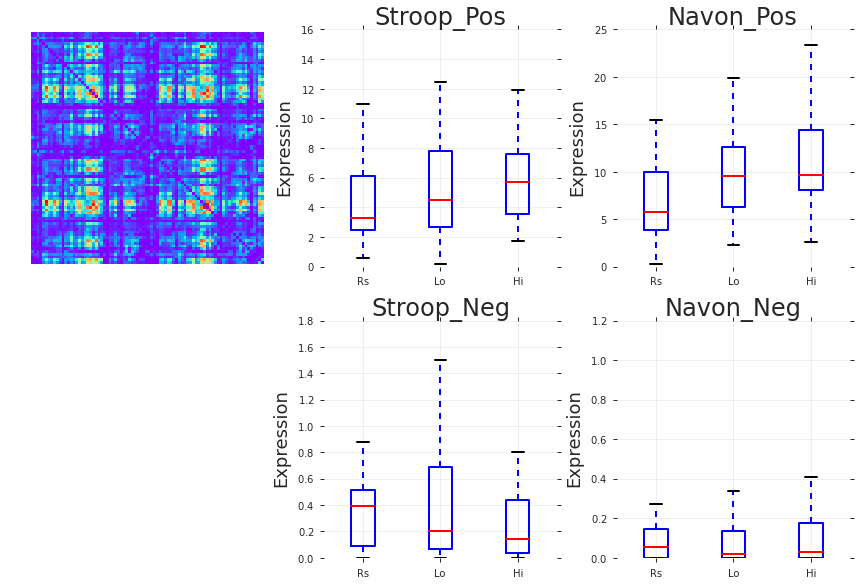

In [17]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop_Pos': {'Rs': ['adj_rs_pos_Stroop'],
                          'Lo': ['adj_lo_pos_Stroop'],
                          'Hi': ['adj_hi_pos_Stroop']},
           'Navon_Pos' : {'Rs': ['adj_rs_pos_Navon'],
                          'Lo': ['adj_lo_pos_Navon'],
                          'Hi': ['adj_hi_pos_Navon']},
           'Stroop_Neg': {'Rs': ['adj_rs_neg_Stroop'],
                          'Lo': ['adj_lo_neg_Stroop'],
                          'Hi': ['adj_hi_neg_Stroop']},
           'Navon_Neg' : {'Rs': ['adj_rs_neg_Navon'],
                          'Lo': ['adj_lo_neg_Navon'],
                          'Hi': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop_Pos', 'Navon_Pos', 'Stroop_Neg', 'Navon_Neg']
key_order = ['Rs', 'Lo', 'Hi']

#sel_fac_ix = xrange(n_fac)
sel_fac_ix = np.sort(real_ix[high_ix])

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():
        subplot_dict = {'title': grp,
                        'xlabel': [],
                        'distrib': [],
                        'stats': []}
        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)

            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            subplot_dict['xlabel'].append(key)
            subplot_dict['distrib'].append(mean_subj_coef)
            
        for key_pair in [[0,1], [0,2], [1,2]]:
            ts, pv = stats.ttest_rel(subplot_dict['distrib'][key_pair[0]],
                                     subplot_dict['distrib'][key_pair[1]])      
            subplot_dict['stats'].append({'name': '{}-{}'.format(subplot_dict['xlabel'][key_pair[0]],
                                                                 subplot_dict['xlabel'][key_pair[1]]),
                                          'tstat': ts,
                                          'pval': pv,
                                          'sig': ''})        
        
        plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_stat['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']
                    for fac_stat in fac_subp['stats']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
sel_fac_within_sig = []
for fac_ii, fac_plot in enumerate(plot_list):
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        for fac_stat in fac_subp['stats']:
            if fac_stat['pval'] < adj_alpha:
                fac_stat['sig'] = '*'
                sel_fac_within_sig.append(fac_ii)
            pval_list.append(fac_stat['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)
sel_fac_within_sig = np.unique(sel_fac_within_sig)

# Plot each result
for fac_ix in sel_fac_within_sig:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]
    
    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        ax.boxplot(fac_subp['distrib'])
        ax.set_xticklabels(fac_subp['xlabel'])
        ax.set_ylabel('Expression')
        ax.set_title(fac_subp['title'])
        #ax.yaxis.set_ticks_position('left')
        #ax.xaxis.set_ticks_position('bottom')


        for fac_stat in fac_subp['stats']:
            print('    %12s: %s: ts: %3.3e pval: %3.3e sig: %s' % 
                  (fac_subp['title'], fac_stat['name'],
                   fac_stat['tstat'], fac_stat['pval'],
                   fac_stat['sig']))
        print('')
            
    plt.show()
    print('\n\n\n')

## Subgraph Expression vs Behavior

### Load Behavioral Data

In [18]:
df_beh = io.loadmat('{}/BehavioralData_CogControlCorrect.mat'.format(path_CoreData))

stroop_lbl = [lbl[0] for lbl in df_beh['StroopLabels'][0]]
navon_lbl = [lbl[0] for lbl in df_beh['NavonLabels'][0]]
stroop_beh = df_beh['StroopCorrectOnly']
navon_beh = df_beh['NavonCorrectOnly']

# Removed subjects
bad_subj_ix = [1, 6]
good_subj_ix = np.setdiff1d(np.arange(stroop_beh.shape[0]), bad_subj_ix)

# Excessive movement
stroop_move = io.loadmat('{}/StroopMove.mat'.format(path_CoreData))['move'][:, 0]
navon_move = io.loadmat('{}/NavonMove.mat'.format(path_CoreData))['move'][:, 0]

stroop_acc = stroop_beh[good_subj_ix, 1]
navon_acc = navon_beh[good_subj_ix, 1]

stroop_interf = stroop_beh[good_subj_ix, 5]
navon_interf = navon_beh[good_subj_ix, 5]

stroop_nointerf = stroop_beh[good_subj_ix, 7]
navon_nointerf = navon_beh[good_subj_ix, 7]

stroop_cost = stroop_interf-stroop_nointerf
navon_cost = navon_interf-navon_nointerf



print('Stroop Labels: {}'.format(stroop_lbl))
print('Navon Labels: {}'.format(navon_lbl))

Stroop Labels: [u'Total Accuracy', u'Interference Accuracy', u'NoInterference Accuracy', u'MeanRT', u'MedianRT', u'InterferenceMeanRT', u'InterferenceMedianRT', u'NoInterferenceMeanRT', u'NoInterferenceMedianRT', u'InterferenceMedianRTMinusMeanRT']
Navon Labels: [u'Total Accuracy', u'ShiftingAccuracy', u'NoShiftingAccuracy', u'MeanRT', u'MedianRT', u'ShiftingMeanRT', u'ShiftingMedianRT', u'NoShiftingMeanRT', u'NoShiftingMedianRT', u'ProportionTotalNonResponses']


### Predicting High Demand Condition RT (Hi)

****************************** Subgraph 11 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

    Stroop: Hi_Pos: rho: 0.06065 pval: 0.75915 sig: 
    Stroop: Hi_Neg: rho: 0.12706 pval: 0.51939 sig: 
    Navon: Hi_Pos: rho: -0.16880 pval: 0.39052 sig: 
    Navon: Hi_Neg: rho: 0.46211 pval: 0.01330 sig: 


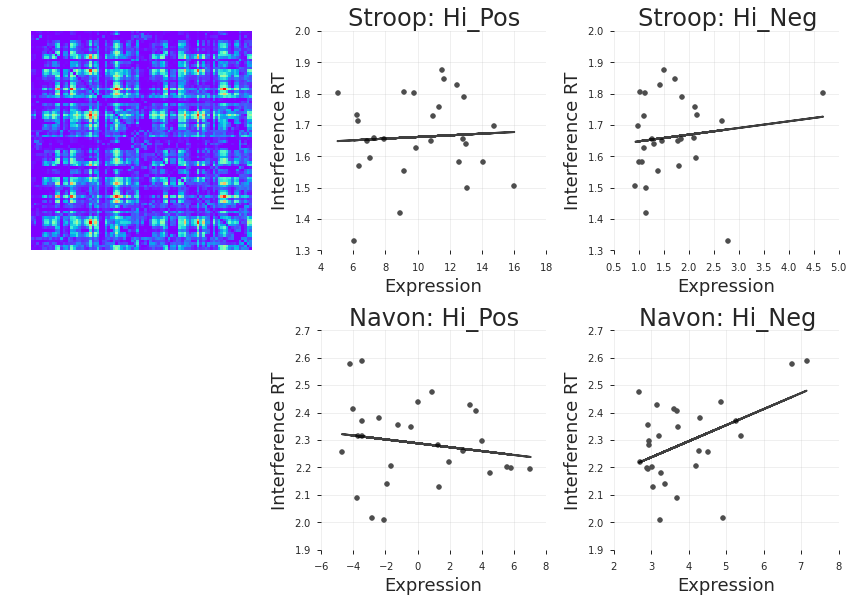





****************************** Subgraph 5 ******************************
    LH_cuneus
    RH_insula
    RH_precentral
    LH_insula
    RH_parsopercularis
    RH_transversetemporal

    Stroop: Hi_Pos: rho: -0.09254 pval: 0.63952 sig: 
    Stroop: Hi_Neg: rho: 0.25347 pval: 0.19311 sig: 
    Navon: Hi_Pos: rho: -0.36436 pval: 0.05662 sig: 
    Navon: Hi_Neg: rho: 0.10550 pval: 0.59315 sig: 


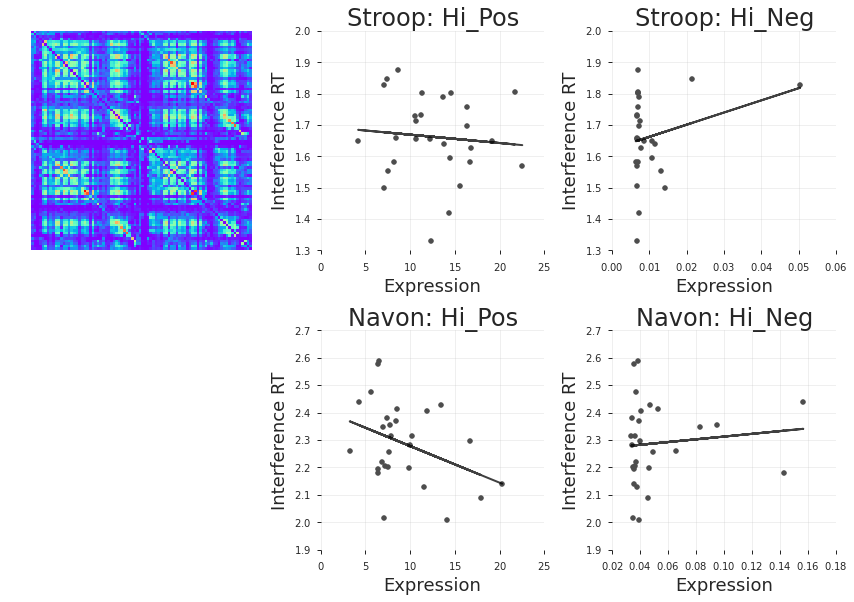





****************************** Subgraph 7 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

    Stroop: Hi_Pos: rho: -0.36170 pval: 0.05858 sig: 
    Stroop: Hi_Neg: rho: 0.26324 pval: 0.17591 sig: 
    Navon: Hi_Pos: rho: -0.16510 pval: 0.40113 sig: 
    Navon: Hi_Neg: rho: -0.17202 pval: 0.38140 sig: 


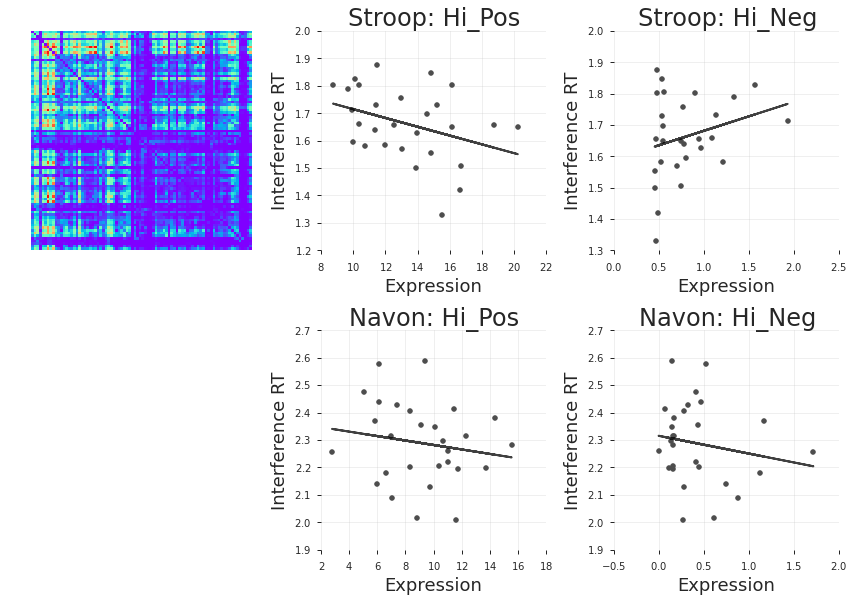





****************************** Subgraph 9 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

    Stroop: Hi_Pos: rho: 0.35150 pval: 0.06662 sig: 
    Stroop: Hi_Neg: rho: 0.22657 pval: 0.24630 sig: 
    Navon: Hi_Pos: rho: 0.27524 pval: 0.15631 sig: 
    Navon: Hi_Neg: rho: -0.08973 pval: 0.64976 sig: 


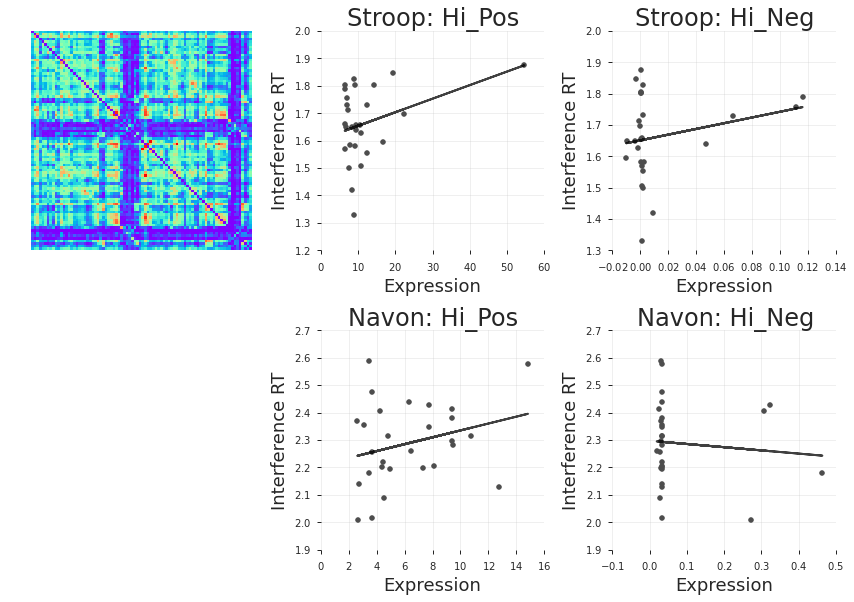





****************************** Subgraph 13 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

    Stroop: Hi_Pos: rho: -0.34361 pval: 0.07341 sig: 
    Stroop: Hi_Neg: rho: 0.17038 pval: 0.38605 sig: 
    Navon: Hi_Pos: rho: 0.03274 pval: 0.86862 sig: 
    Navon: Hi_Neg: rho: -0.07929 pval: 0.68837 sig: 


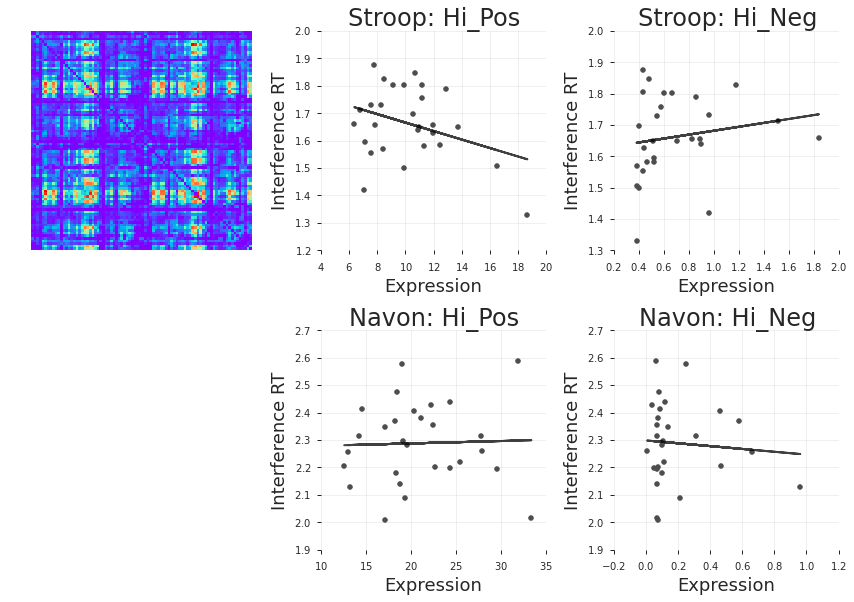





****************************** Subgraph 8 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

    Stroop: Hi_Pos: rho: -0.33229 pval: 0.08405 sig: 
    Stroop: Hi_Neg: rho: 0.17401 pval: 0.37584 sig: 
    Navon: Hi_Pos: rho: 0.13623 pval: 0.48941 sig: 
    Navon: Hi_Neg: rho: -0.32374 pval: 0.09285 sig: 


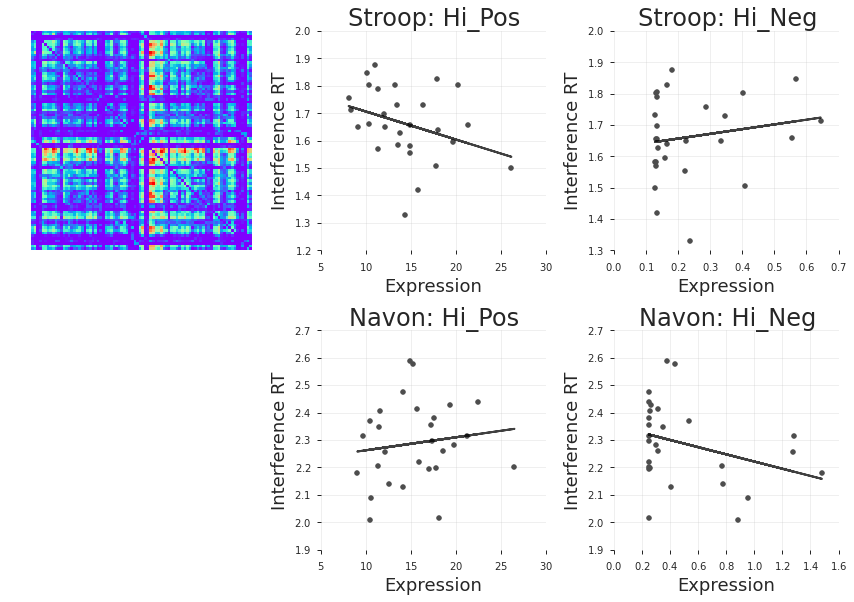





****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

    Stroop: Hi_Pos: rho: 0.00995 pval: 0.95993 sig: 
    Stroop: Hi_Neg: rho: -0.01560 pval: 0.93718 sig: 
    Navon: Hi_Pos: rho: 0.29851 pval: 0.12284 sig: 
    Navon: Hi_Neg: rho: 0.00091 pval: 0.99635 sig: 


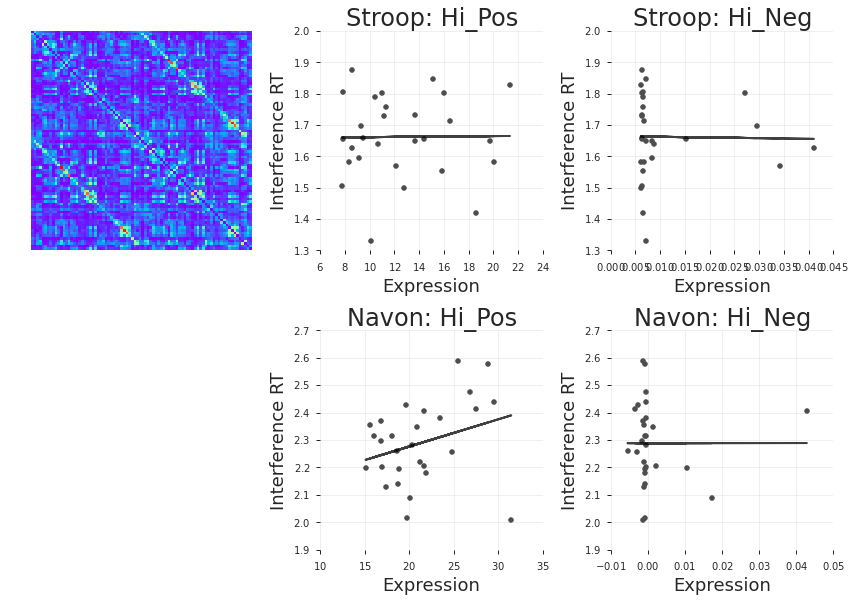





****************************** Subgraph 10 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

    Stroop: Hi_Pos: rho: 0.05846 pval: 0.76760 sig: 
    Stroop: Hi_Neg: rho: 0.21792 pval: 0.26527 sig: 
    Navon: Hi_Pos: rho: -0.05458 pval: 0.78266 sig: 
    Navon: Hi_Neg: rho: 0.27742 pval: 0.15293 sig: 


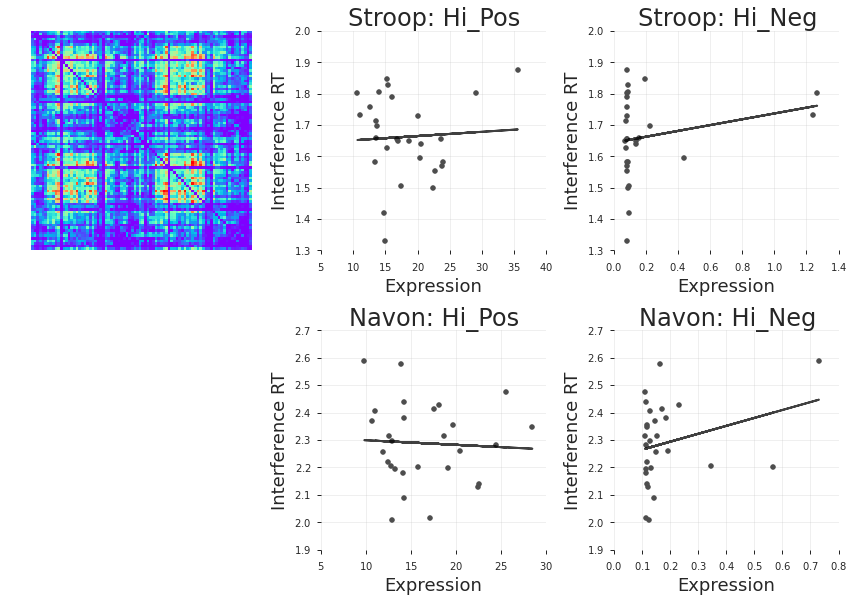





****************************** Subgraph 4 ******************************
    RH_isthmuscingulate
    LH_isthmuscingulate
    RH_precuneus
    RH_pericalcarine
    LH_pericalcarine
    LH_paracentral

    Stroop: Hi_Pos: rho: -0.20648 pval: 0.29180 sig: 
    Stroop: Hi_Neg: rho: 0.01874 pval: 0.92459 sig: 
    Navon: Hi_Pos: rho: -0.16386 pval: 0.40475 sig: 
    Navon: Hi_Neg: rho: 0.23908 pval: 0.22047 sig: 


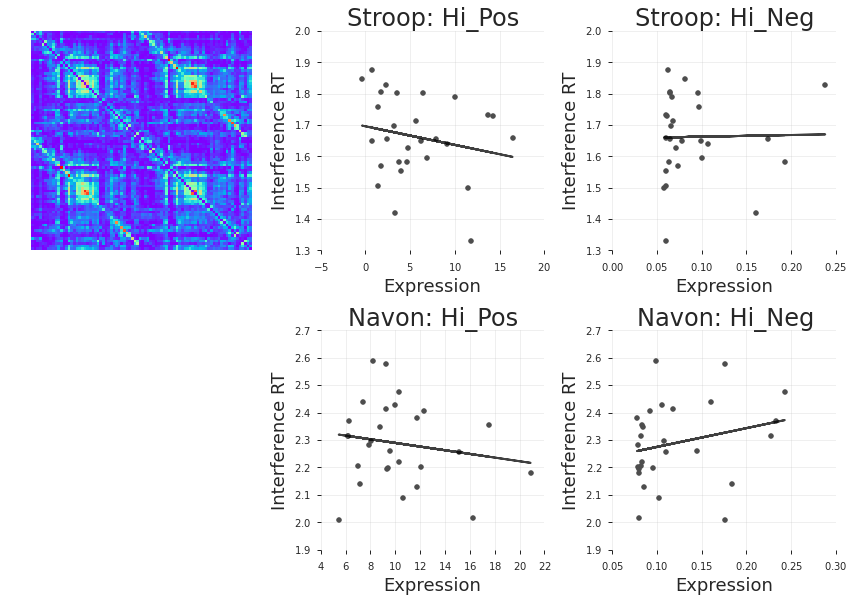





****************************** Subgraph 3 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

    Stroop: Hi_Pos: rho: 0.06333 pval: 0.74887 sig: 
    Stroop: Hi_Neg: rho: 0.07607 pval: 0.70043 sig: 
    Navon: Hi_Pos: rho: -0.06906 pval: 0.72694 sig: 
    Navon: Hi_Neg: rho: 0.22755 pval: 0.24421 sig: 


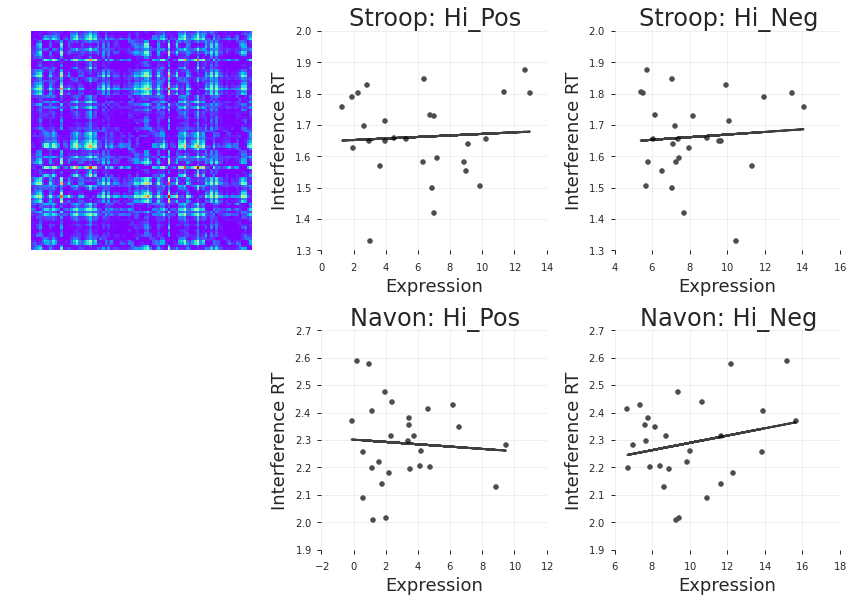





****************************** Subgraph 12 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Stroop: Hi_Pos: rho: -0.03276 pval: 0.86854 sig: 
    Stroop: Hi_Neg: rho: 0.17027 pval: 0.38635 sig: 
    Navon: Hi_Pos: rho: -0.19671 pval: 0.31571 sig: 
    Navon: Hi_Neg: rho: -0.03954 pval: 0.84166 sig: 


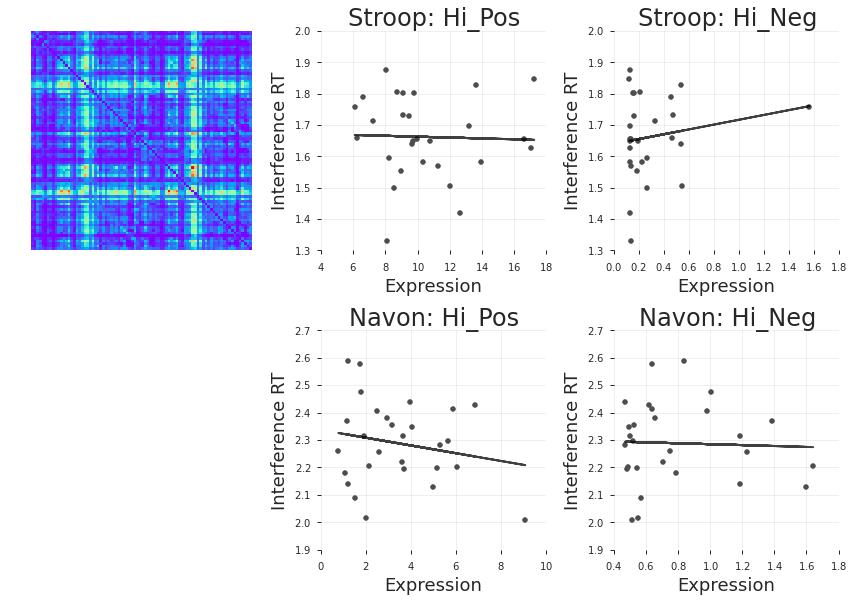





****************************** Subgraph 2 ******************************
    RH_accumbensarea
    LH_accumbensarea
    RH_lateralorbitofrontal
    RH_medialorbitofrontal
    LH_lateralorbitofrontal
    RH_frontalpole

    Stroop: Hi_Pos: rho: 0.15489 pval: 0.43130 sig: 
    Stroop: Hi_Neg: rho: -0.03639 pval: 0.85413 sig: 
    Navon: Hi_Pos: rho: -0.19078 pval: 0.33082 sig: 
    Navon: Hi_Neg: rho: 0.07877 pval: 0.69033 sig: 


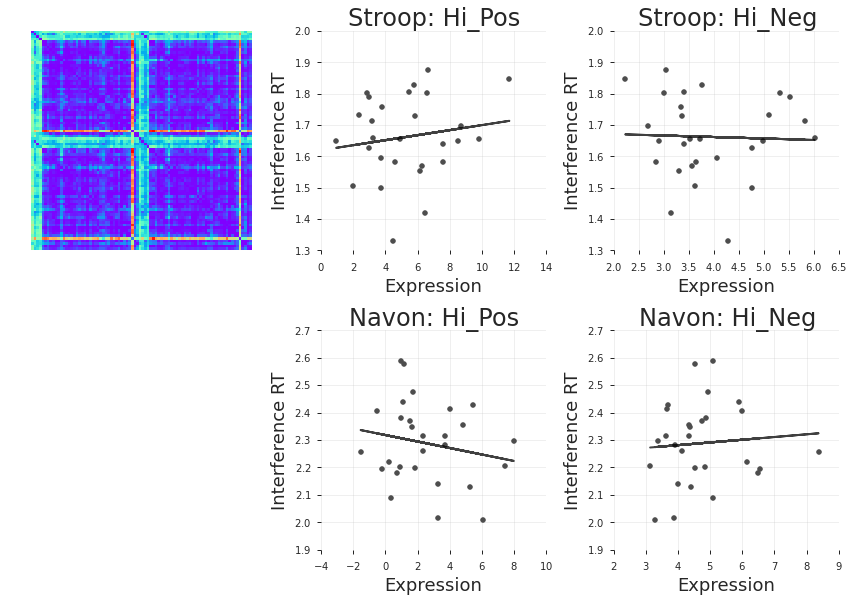





****************************** Subgraph 6 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

    Stroop: Hi_Pos: rho: -0.10623 pval: 0.59057 sig: 
    Stroop: Hi_Neg: rho: 0.07930 pval: 0.68832 sig: 
    Navon: Hi_Pos: rho: -0.08440 pval: 0.66936 sig: 
    Navon: Hi_Neg: rho: -0.05559 pval: 0.77874 sig: 


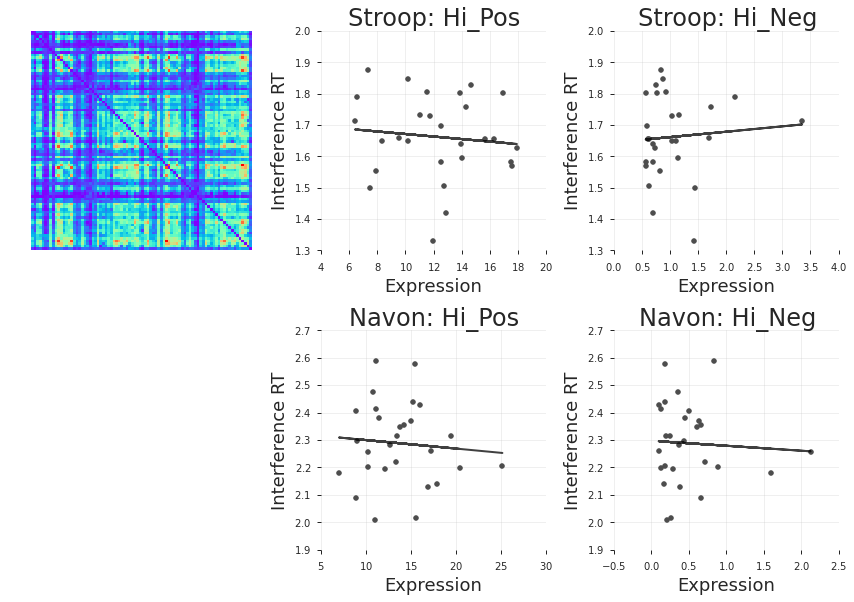

In [19]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Hi_Pos': ['adj_hi_pos_Stroop'],
                      'Hi_Neg': ['adj_hi_neg_Stroop']},
           'Navon' : {'Hi_Pos': ['adj_hi_pos_Navon'],
                      'Hi_Neg': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Hi_Pos', 'Hi_Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_interf],
           'Navon': [navon_move, navon_interf]}

#sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]
sel_fac_ix = np.sort(real_ix[high_ix])[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            

            m, b, rho, pval, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': rho,
                                     'pval': pval,
                                     'slope': m,
                                     "interc": b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting High Demand Condition RT (Hi-Lo)

****************************** Subgraph 5 ******************************
    LH_cuneus
    RH_insula
    RH_precentral
    LH_insula
    RH_parsopercularis
    RH_transversetemporal

     Stroop: Pos: rho: 0.31628 pval: 0.10106 sig: 
     Stroop: Neg: rho: -0.17310 pval: 0.37838 sig: 
      Navon: Pos: rho: -0.55773 pval: 0.00204 sig: 
      Navon: Neg: rho: 0.23626 pval: 0.22613 sig: 


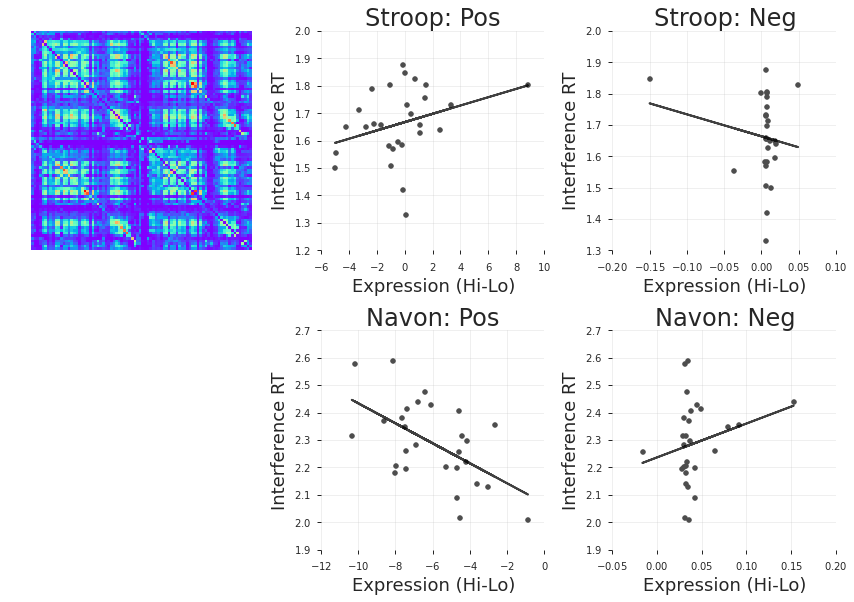





****************************** Subgraph 7 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

     Stroop: Pos: rho: -0.31580 pval: 0.10162 sig: 
     Stroop: Neg: rho: 0.45548 pval: 0.01486 sig: 
      Navon: Pos: rho: 0.05366 pval: 0.78626 sig: 
      Navon: Neg: rho: -0.26390 pval: 0.17479 sig: 


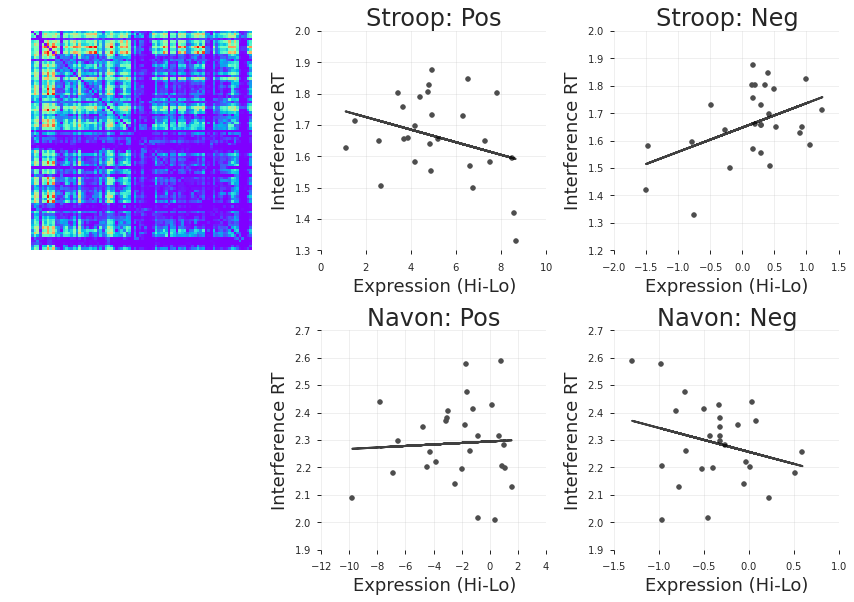





****************************** Subgraph 8 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

     Stroop: Pos: rho: -0.37750 pval: 0.04766 sig: 
     Stroop: Neg: rho: 0.15720 pval: 0.42437 sig: 
      Navon: Pos: rho: 0.19160 pval: 0.32871 sig: 
      Navon: Neg: rho: -0.34879 pval: 0.06890 sig: 


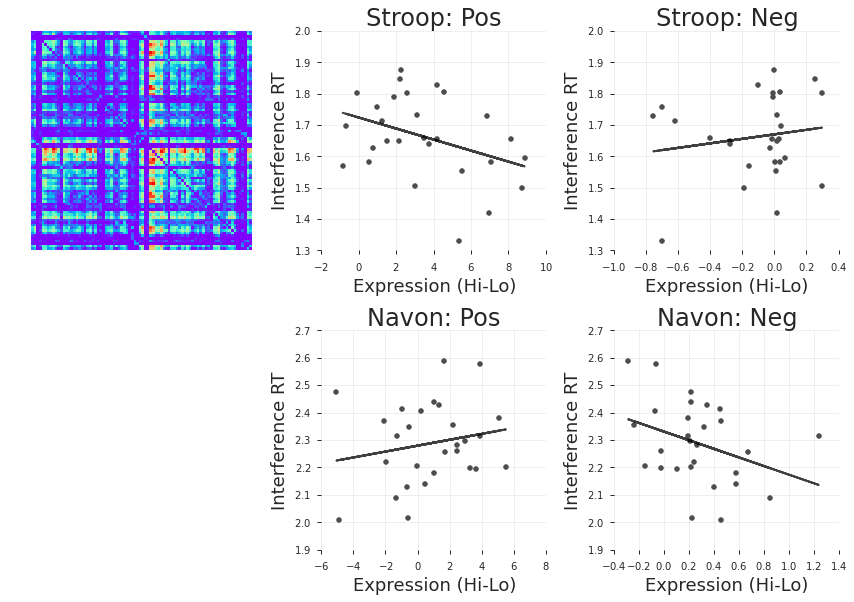





****************************** Subgraph 12 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

     Stroop: Pos: rho: 0.17703 pval: 0.36748 sig: 
     Stroop: Neg: rho: 0.05090 pval: 0.79701 sig: 
      Navon: Pos: rho: -0.36845 pval: 0.05370 sig: 
      Navon: Neg: rho: -0.04510 pval: 0.81973 sig: 


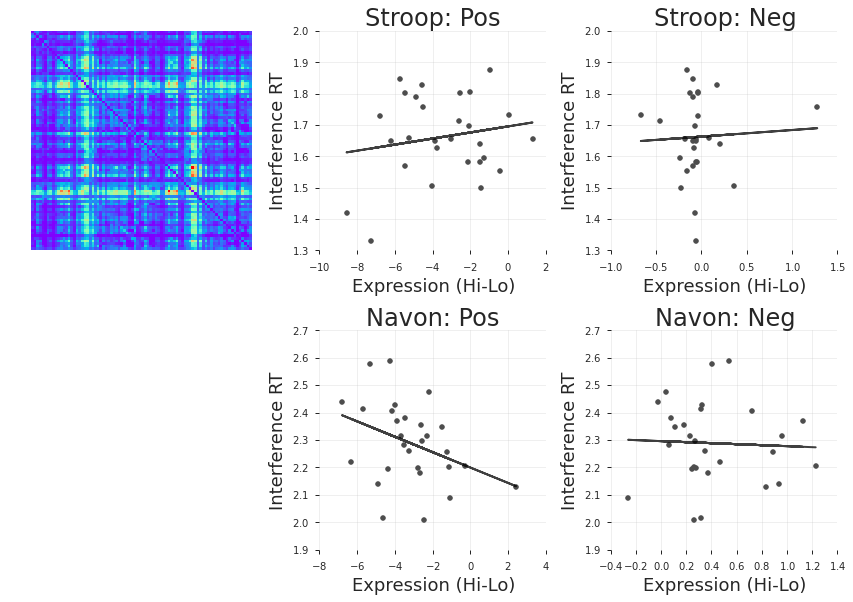





****************************** Subgraph 11 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

     Stroop: Pos: rho: 0.02888 pval: 0.88401 sig: 
     Stroop: Neg: rho: 0.31840 pval: 0.09868 sig: 
      Navon: Pos: rho: -0.12420 pval: 0.52890 sig: 
      Navon: Neg: rho: 0.36486 pval: 0.05625 sig: 


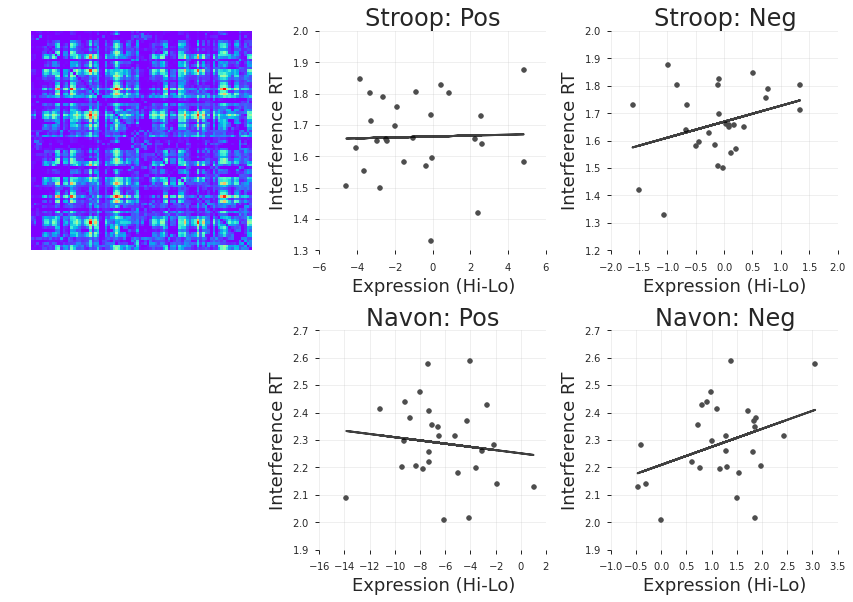





****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

     Stroop: Pos: rho: -0.10475 pval: 0.59580 sig: 
     Stroop: Neg: rho: 0.07215 pval: 0.71521 sig: 
      Navon: Pos: rho: 0.30382 pval: 0.11600 sig: 
      Navon: Neg: rho: -0.03396 pval: 0.86380 sig: 


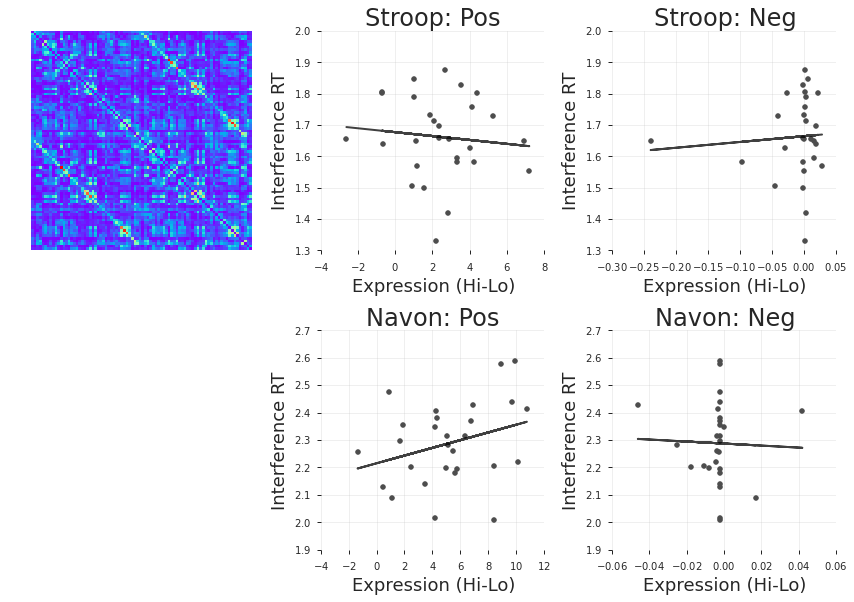





****************************** Subgraph 10 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

     Stroop: Pos: rho: 0.09498 pval: 0.63068 sig: 
     Stroop: Neg: rho: 0.29683 pval: 0.12506 sig: 
      Navon: Pos: rho: -0.12262 pval: 0.53420 sig: 
      Navon: Neg: rho: -0.05837 pval: 0.76797 sig: 


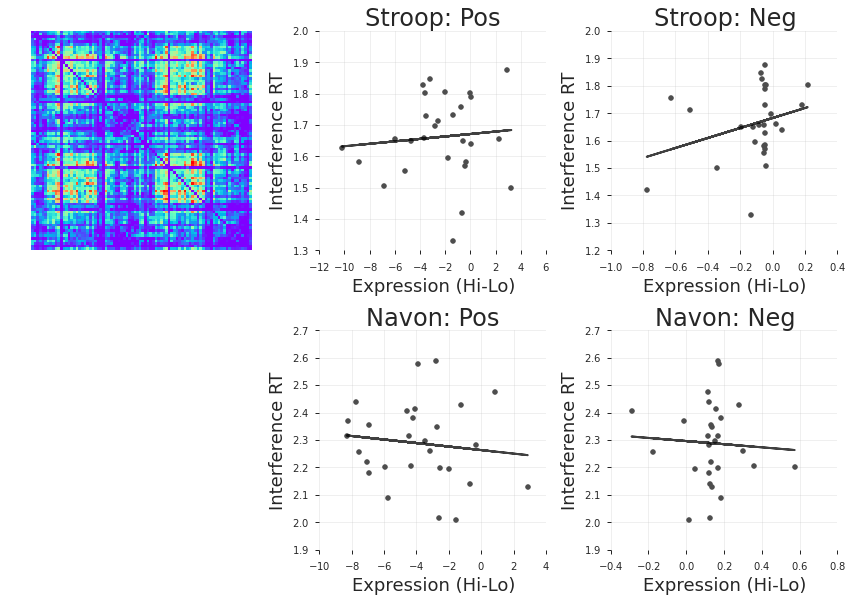





****************************** Subgraph 6 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

     Stroop: Pos: rho: 0.11873 pval: 0.54734 sig: 
     Stroop: Neg: rho: -0.13145 pval: 0.50493 sig: 
      Navon: Pos: rho: -0.29301 pval: 0.13022 sig: 
      Navon: Neg: rho: 0.11698 pval: 0.55330 sig: 


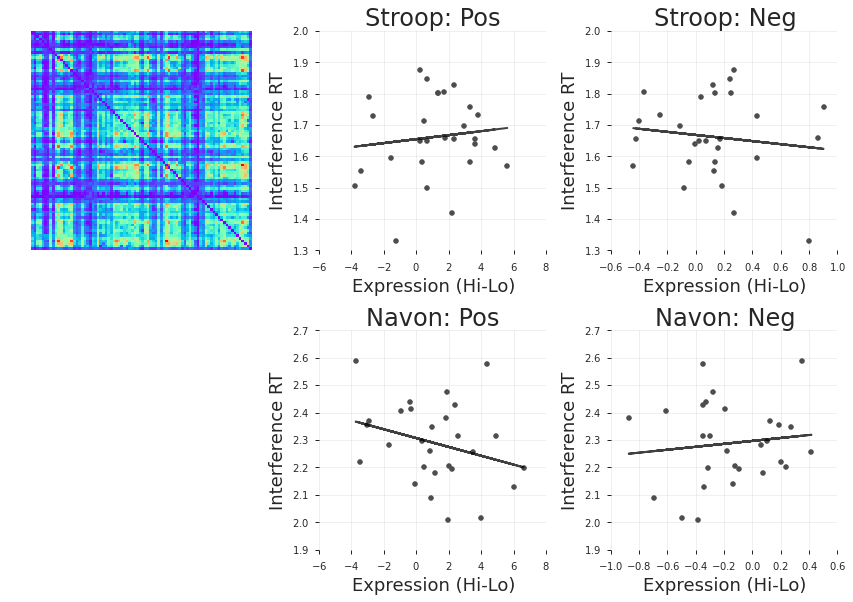





****************************** Subgraph 13 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

     Stroop: Pos: rho: -0.28969 pval: 0.13485 sig: 
     Stroop: Neg: rho: 0.10183 pval: 0.60613 sig: 
      Navon: Pos: rho: 0.28447 pval: 0.14234 sig: 
      Navon: Neg: rho: 0.15882 pval: 0.41955 sig: 


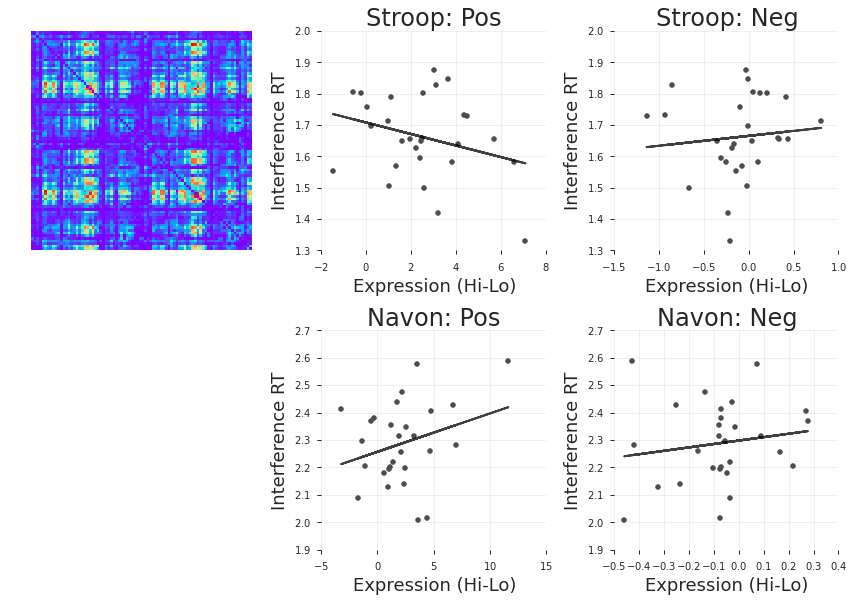





****************************** Subgraph 4 ******************************
    RH_isthmuscingulate
    LH_isthmuscingulate
    RH_precuneus
    RH_pericalcarine
    LH_pericalcarine
    LH_paracentral

     Stroop: Pos: rho: -0.27166 pval: 0.16199 sig: 
     Stroop: Neg: rho: -0.13238 pval: 0.50188 sig: 
      Navon: Pos: rho: 0.27080 pval: 0.16337 sig: 
      Navon: Neg: rho: 0.08612 pval: 0.66303 sig: 


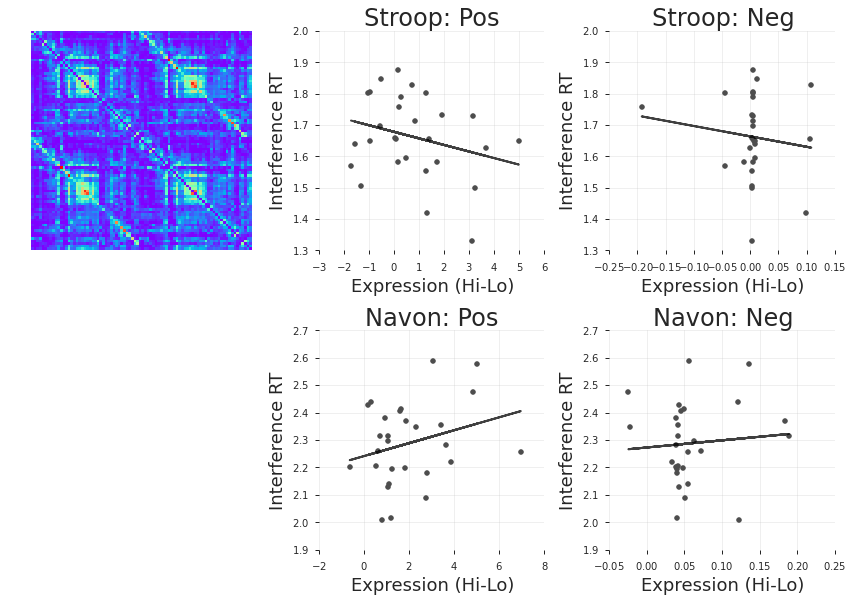





****************************** Subgraph 2 ******************************
    RH_accumbensarea
    LH_accumbensarea
    RH_lateralorbitofrontal
    RH_medialorbitofrontal
    LH_lateralorbitofrontal
    RH_frontalpole

     Stroop: Pos: rho: 0.01149 pval: 0.95372 sig: 
     Stroop: Neg: rho: -0.02422 pval: 0.90262 sig: 
      Navon: Pos: rho: -0.26512 pval: 0.17274 sig: 
      Navon: Neg: rho: 0.12895 pval: 0.51314 sig: 


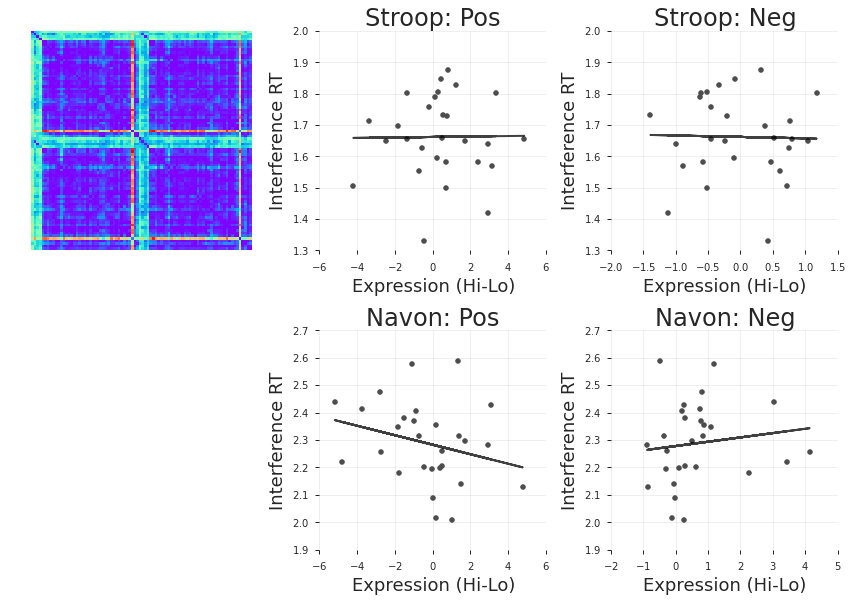





****************************** Subgraph 3 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

     Stroop: Pos: rho: 0.18576 pval: 0.34394 sig: 
     Stroop: Neg: rho: 0.16240 pval: 0.40901 sig: 
      Navon: Pos: rho: 0.01765 pval: 0.92895 sig: 
      Navon: Neg: rho: 0.24486 pval: 0.20918 sig: 


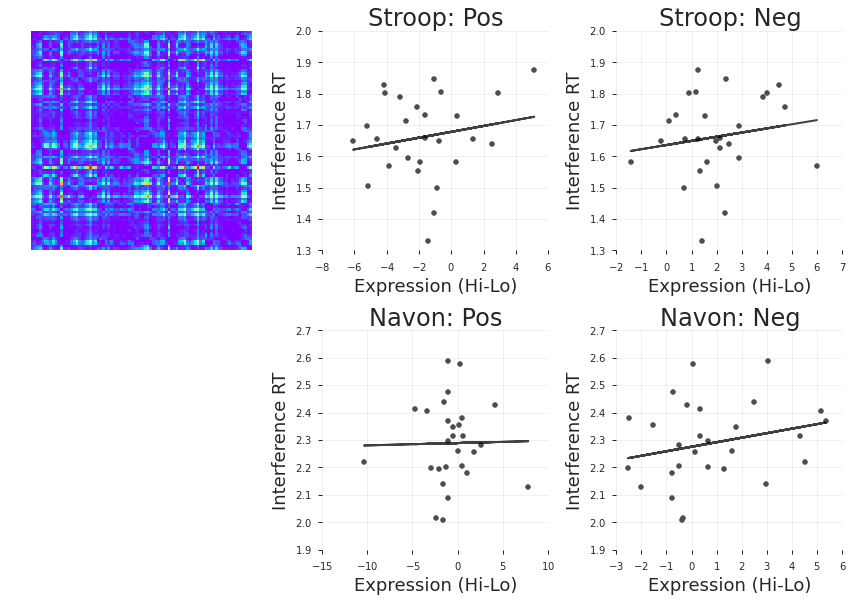





****************************** Subgraph 9 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

     Stroop: Pos: rho: 0.15109 pval: 0.44281 sig: 
     Stroop: Neg: rho: 0.11627 pval: 0.55574 sig: 
      Navon: Pos: rho: 0.05150 pval: 0.79468 sig: 
      Navon: Neg: rho: -0.04752 pval: 0.81023 sig: 


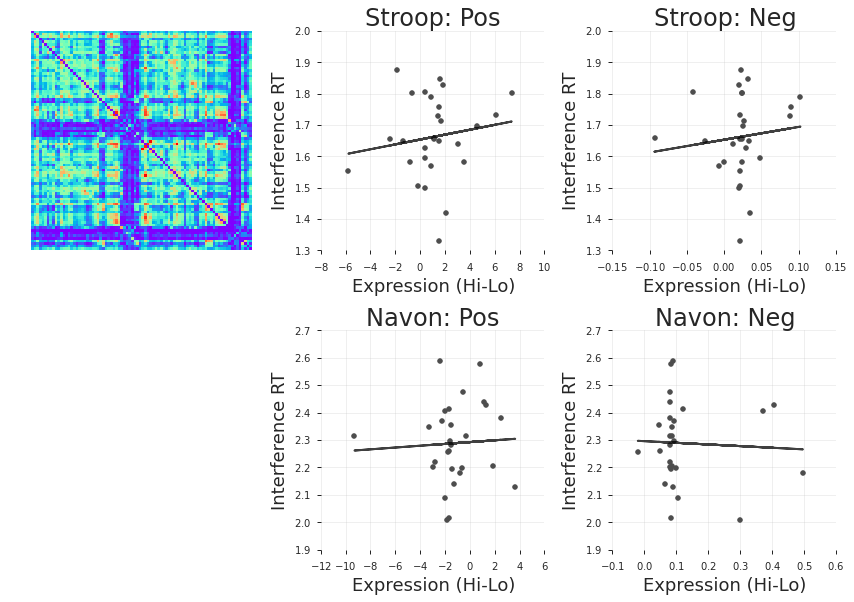

In [20]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Pos': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                      'Neg': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']},
           'Navon' : {'Pos': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
                      'Neg': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Pos', 'Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_interf],
           'Navon': [navon_move, navon_interf]}

#sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]
sel_fac_ix = np.sort(real_ix[high_ix])[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_coef_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_coef_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)            
            mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            

            m, b, rho, pval, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': rho,
                                     'pval': pval,
                                     'slope': m,
                                     "interc": b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi-Lo)')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting High Demand Condition Accuracy (Hi)

****************************** Subgraph 8 ******************************
    LH_parstriangularis
    LH_parsopercularis
    LH_caudalmiddlefrontal
    LH_bankssts
    LH_parsorbitalis
    LH_rostralmiddlefrontal

    Stroop: Hi_Pos: rho: -0.16444 pval: 0.40306 sig: 
    Stroop: Hi_Neg: rho: 0.12713 pval: 0.51915 sig: 
    Navon: Hi_Pos: rho: -0.33138 pval: 0.08496 sig: 
    Navon: Hi_Neg: rho: 0.40531 pval: 0.03238 sig: 


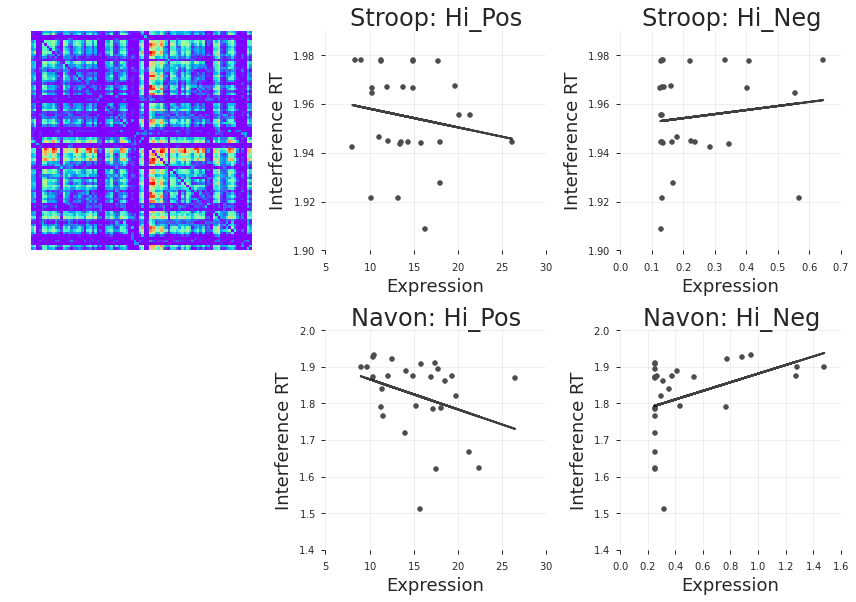





****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

    Stroop: Hi_Pos: rho: -0.19798 pval: 0.31254 sig: 
    Stroop: Hi_Neg: rho: 0.16502 pval: 0.40138 sig: 
    Navon: Hi_Pos: rho: -0.40394 pval: 0.03303 sig: 
    Navon: Hi_Neg: rho: 0.01969 pval: 0.92077 sig: 


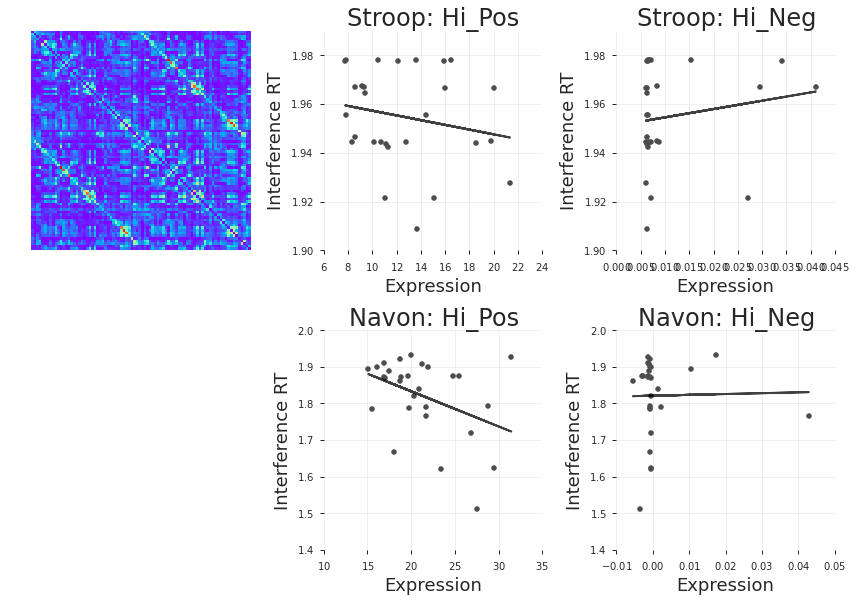





****************************** Subgraph 5 ******************************
    LH_cuneus
    RH_insula
    RH_precentral
    LH_insula
    RH_parsopercularis
    RH_transversetemporal

    Stroop: Hi_Pos: rho: 0.28166 pval: 0.14649 sig: 
    Stroop: Hi_Neg: rho: -0.34186 pval: 0.07498 sig: 
    Navon: Hi_Pos: rho: 0.36301 pval: 0.05761 sig: 
    Navon: Hi_Neg: rho: -0.18884 pval: 0.33586 sig: 


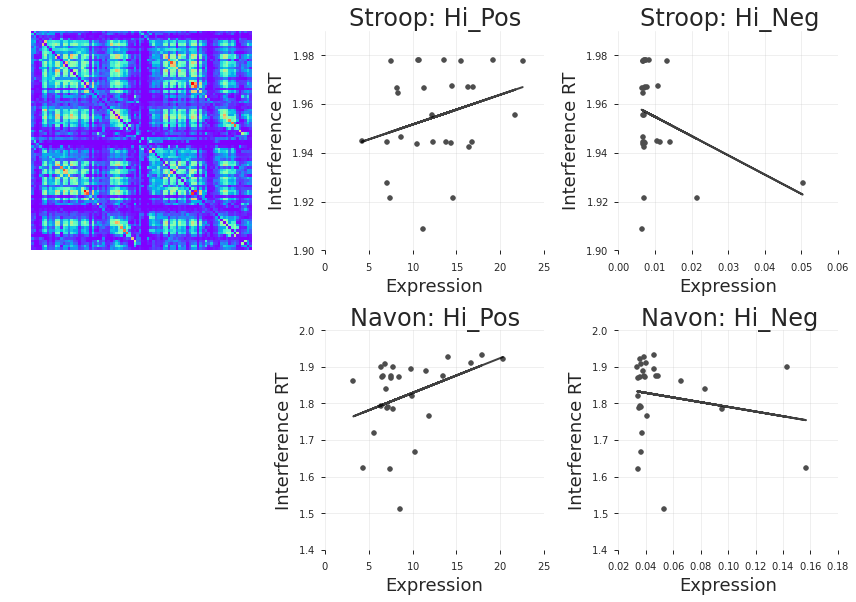





****************************** Subgraph 11 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

    Stroop: Hi_Pos: rho: -0.04298 pval: 0.82810 sig: 
    Stroop: Hi_Neg: rho: 0.12197 pval: 0.53638 sig: 
    Navon: Hi_Pos: rho: 0.28301 pval: 0.14448 sig: 
    Navon: Hi_Neg: rho: -0.08027 pval: 0.68472 sig: 


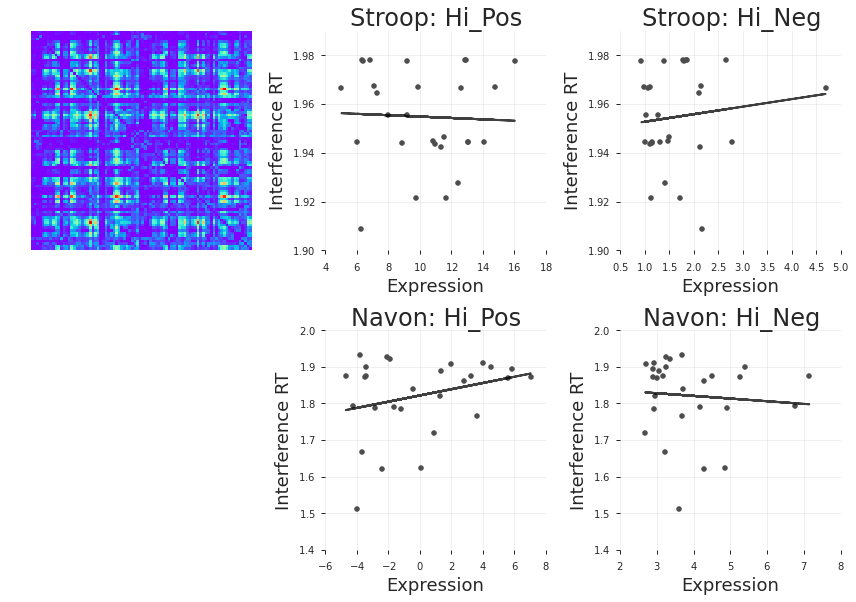





****************************** Subgraph 7 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

    Stroop: Hi_Pos: rho: -0.12003 pval: 0.54291 sig: 
    Stroop: Hi_Neg: rho: 0.10114 pval: 0.60857 sig: 
    Navon: Hi_Pos: rho: -0.17770 pval: 0.36566 sig: 
    Navon: Hi_Neg: rho: 0.26556 pval: 0.17200 sig: 


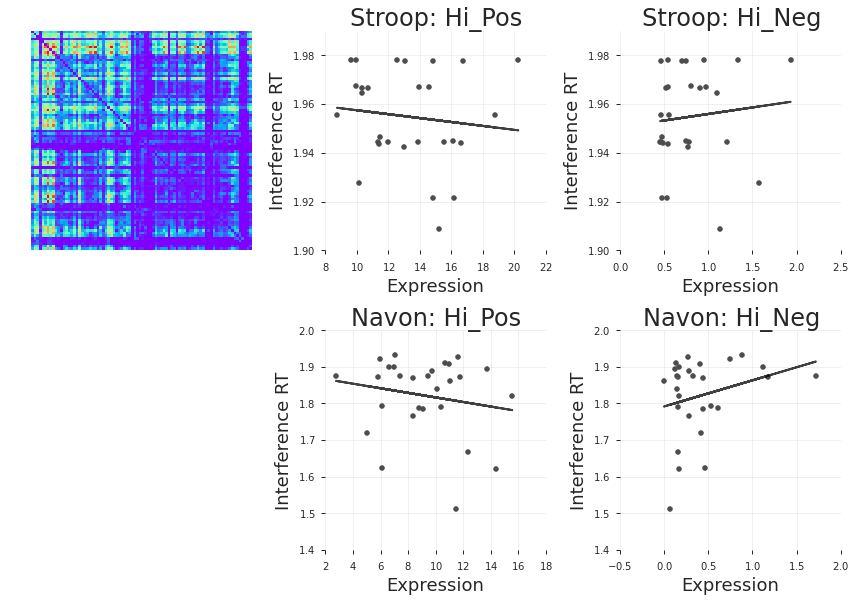





****************************** Subgraph 6 ******************************
    LH_paracentral
    LH_hyppocampus
    RH_paracentral
    LH_amygdala
    LH_rostralanteriorcingulate
    LH_medialorbitofrontal

    Stroop: Hi_Pos: rho: -0.12559 pval: 0.52425 sig: 
    Stroop: Hi_Neg: rho: 0.17687 pval: 0.36793 sig: 
    Navon: Hi_Pos: rho: 0.05350 pval: 0.78688 sig: 
    Navon: Hi_Neg: rho: 0.25887 pval: 0.18346 sig: 


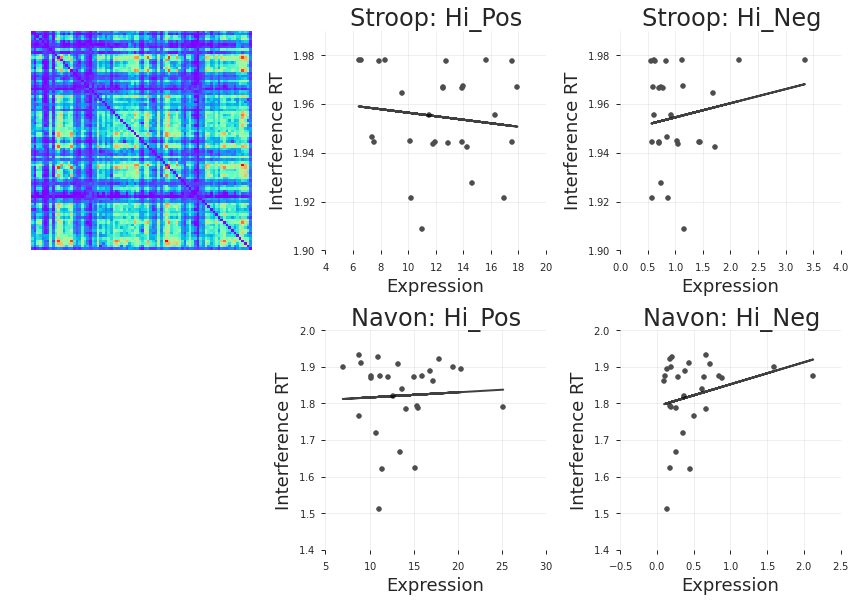





****************************** Subgraph 3 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

    Stroop: Hi_Pos: rho: -0.20213 pval: 0.30231 sig: 
    Stroop: Hi_Neg: rho: 0.20201 pval: 0.30260 sig: 
    Navon: Hi_Pos: rho: -0.13248 pval: 0.50156 sig: 
    Navon: Hi_Neg: rho: 0.25762 pval: 0.18566 sig: 


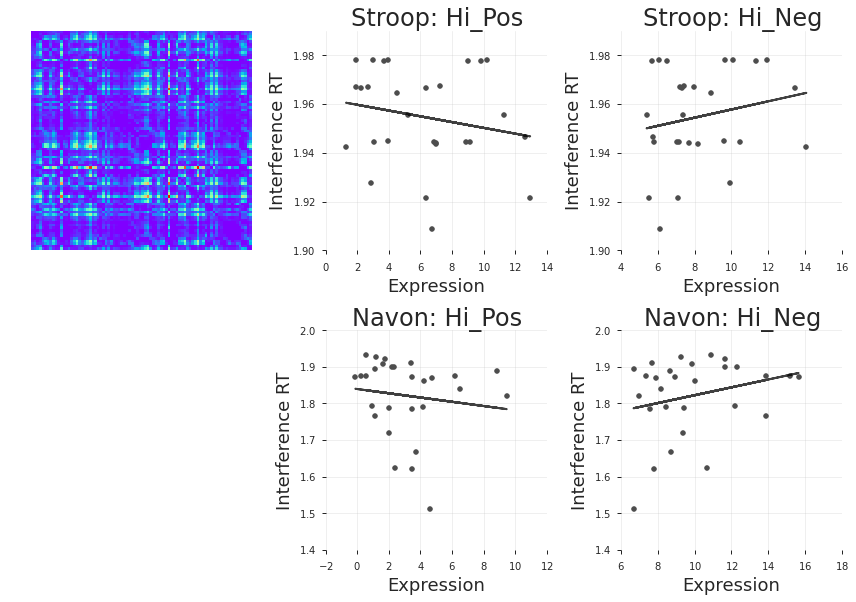





****************************** Subgraph 10 ******************************
    RH_paracentral
    LH_paracentral
    LH_cuneus
    LH_lingual
    RH_postcentral
    RH_precentral

    Stroop: Hi_Pos: rho: 0.00838 pval: 0.96623 sig: 
    Stroop: Hi_Neg: rho: -0.22979 pval: 0.23947 sig: 
    Navon: Hi_Pos: rho: -0.01221 pval: 0.95084 sig: 
    Navon: Hi_Neg: rho: 0.06994 pval: 0.72359 sig: 


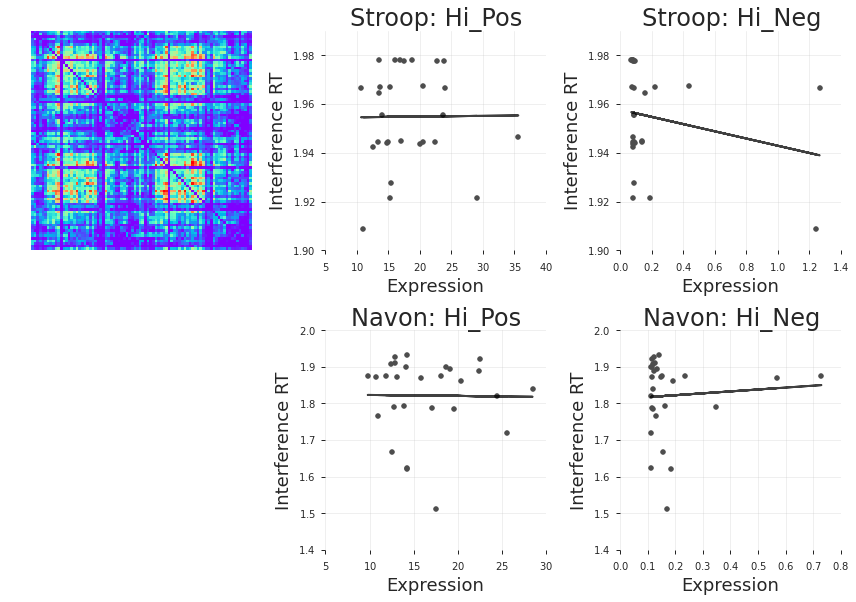





****************************** Subgraph 9 ******************************
    LH_frontalpole
    LH_parahippocampal
    RH_frontalpole
    LH_isthmuscingulate
    RH_parahippocampal
    LH_posteriorcingulate

    Stroop: Hi_Pos: rho: -0.14839 pval: 0.45109 sig: 
    Stroop: Hi_Neg: rho: -0.00514 pval: 0.97928 sig: 
    Navon: Hi_Pos: rho: -0.18930 pval: 0.33465 sig: 
    Navon: Hi_Neg: rho: 0.18247 pval: 0.35272 sig: 


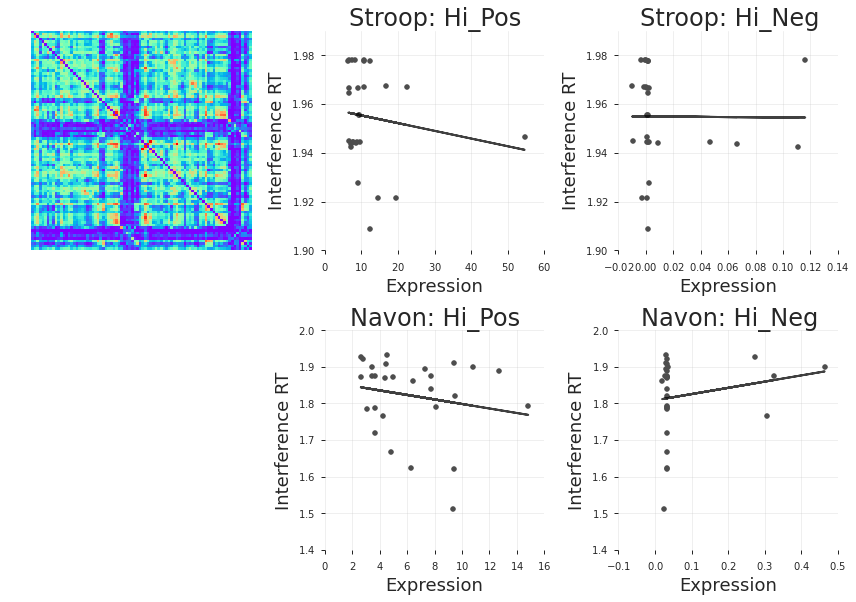





****************************** Subgraph 12 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Stroop: Hi_Pos: rho: -0.15993 pval: 0.41626 sig: 
    Stroop: Hi_Neg: rho: -0.14035 pval: 0.47627 sig: 
    Navon: Hi_Pos: rho: -0.03601 pval: 0.85565 sig: 
    Navon: Hi_Neg: rho: 0.17539 pval: 0.37201 sig: 


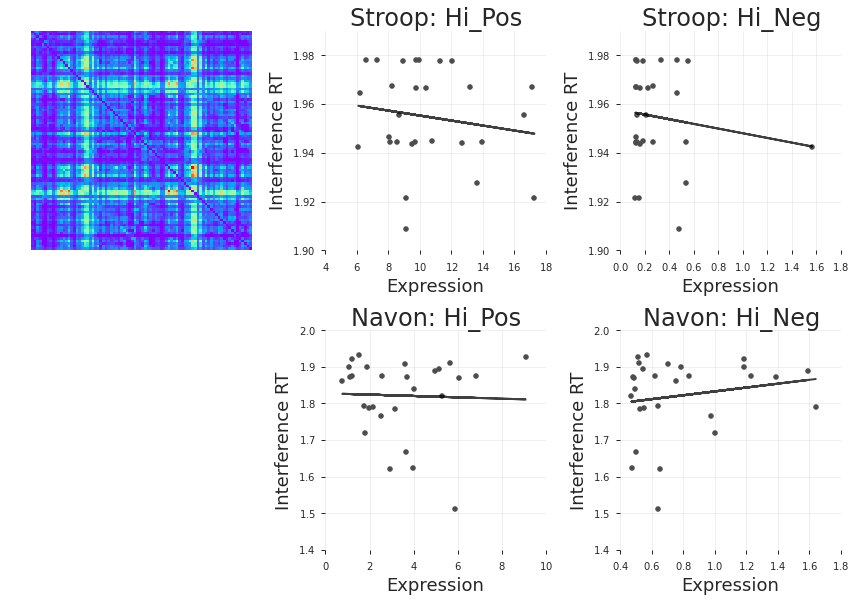





****************************** Subgraph 4 ******************************
    RH_isthmuscingulate
    LH_isthmuscingulate
    RH_precuneus
    RH_pericalcarine
    LH_pericalcarine
    LH_paracentral

    Stroop: Hi_Pos: rho: -0.15299 pval: 0.43703 sig: 
    Stroop: Hi_Neg: rho: -0.16846 pval: 0.39149 sig: 
    Navon: Hi_Pos: rho: 0.02660 pval: 0.89310 sig: 
    Navon: Hi_Neg: rho: 0.03563 pval: 0.85716 sig: 


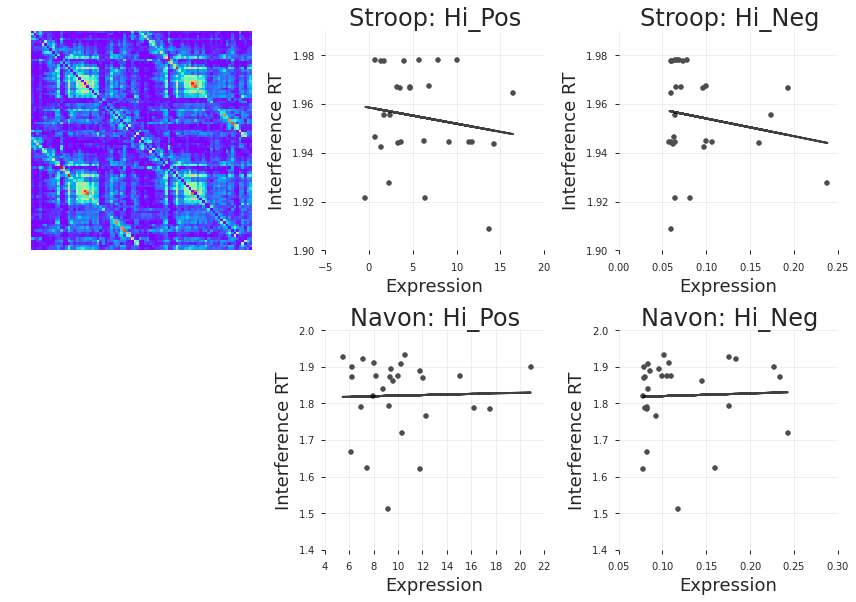





****************************** Subgraph 2 ******************************
    RH_accumbensarea
    LH_accumbensarea
    RH_lateralorbitofrontal
    RH_medialorbitofrontal
    LH_lateralorbitofrontal
    RH_frontalpole

    Stroop: Hi_Pos: rho: -0.05981 pval: 0.76239 sig: 
    Stroop: Hi_Neg: rho: 0.16751 pval: 0.39421 sig: 
    Navon: Hi_Pos: rho: 0.00296 pval: 0.98806 sig: 
    Navon: Hi_Neg: rho: 0.05926 pval: 0.76452 sig: 


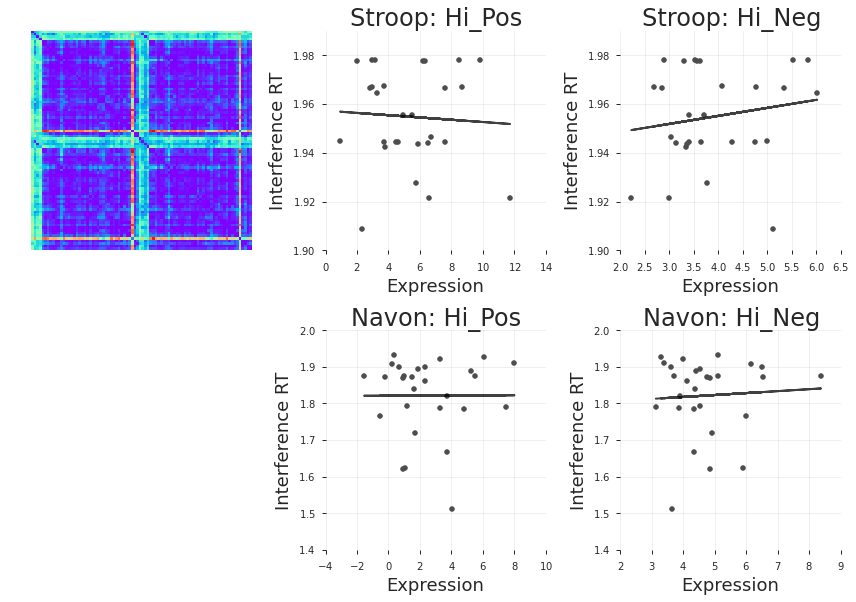





****************************** Subgraph 13 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

    Stroop: Hi_Pos: rho: 0.16057 pval: 0.41437 sig: 
    Stroop: Hi_Neg: rho: -0.05013 pval: 0.80001 sig: 
    Navon: Hi_Pos: rho: -0.02406 pval: 0.90329 sig: 
    Navon: Hi_Neg: rho: 0.15096 pval: 0.44321 sig: 


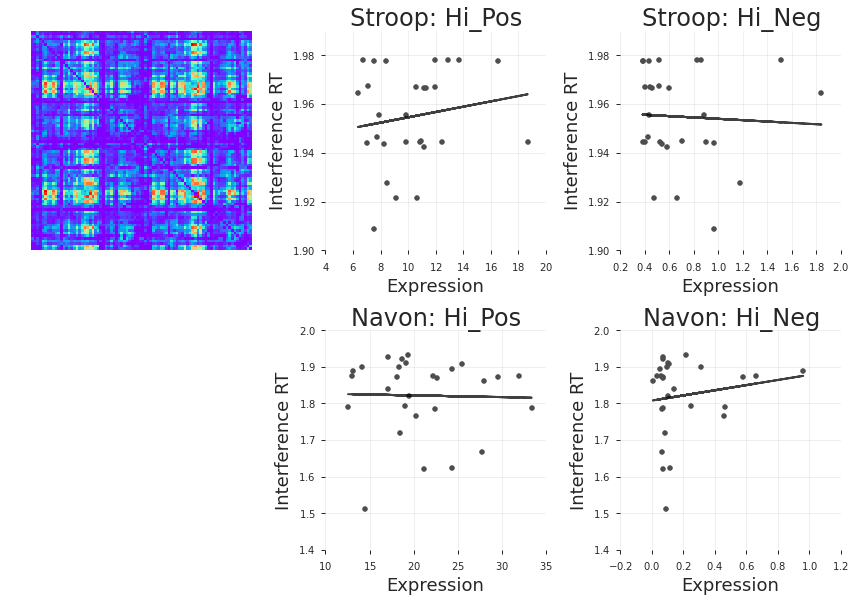

In [21]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Hi_Pos': ['adj_hi_pos_Stroop'],
                      'Hi_Neg': ['adj_hi_neg_Stroop']},
           'Navon' : {'Hi_Pos': ['adj_hi_pos_Navon'],
                      'Hi_Neg': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Hi_Pos', 'Hi_Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_acc],
           'Navon': [navon_move, navon_acc]}

#sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]
sel_fac_ix = np.sort(real_ix[high_ix])[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            

            m, b, rho, pval, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': rho,
                                     'pval': pval,
                                     'slope': m,
                                     "interc": b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting High Demand Condition Accuracy (Hi-Lo)

****************************** Subgraph 6 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    RH_pericalcarine
    RH_lingual
    LH_lingual

     Stroop: Pos: rho: -0.34390 pval: 0.07315 sig: 
     Stroop: Neg: rho: 0.53799 pval: 0.00315 sig: 
      Navon: Pos: rho: 0.19500 pval: 0.32002 sig: 
      Navon: Neg: rho: -0.16261 pval: 0.40837 sig: 


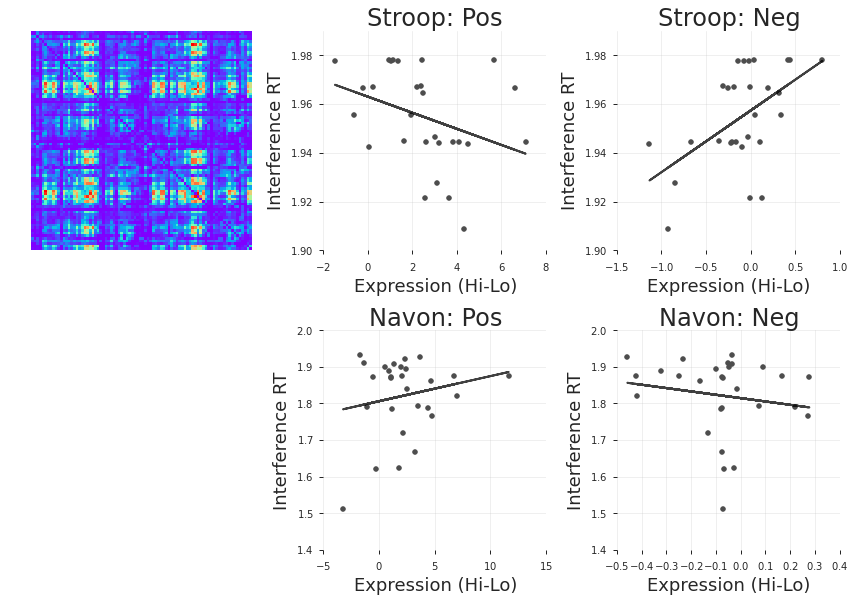





****************************** Subgraph 5 ******************************
    RH_transversetemporal
    RH_lateraloccipital
    LH_lateraloccipital
    LH_transversetemporal
    RH_postcentral
    RH_insula

     Stroop: Pos: rho: -0.25126 pval: 0.19715 sig: 
     Stroop: Neg: rho: 0.50629 pval: 0.00598 sig: 
      Navon: Pos: rho: 0.33344 pval: 0.08293 sig: 
      Navon: Neg: rho: -0.17026 pval: 0.38639 sig: 


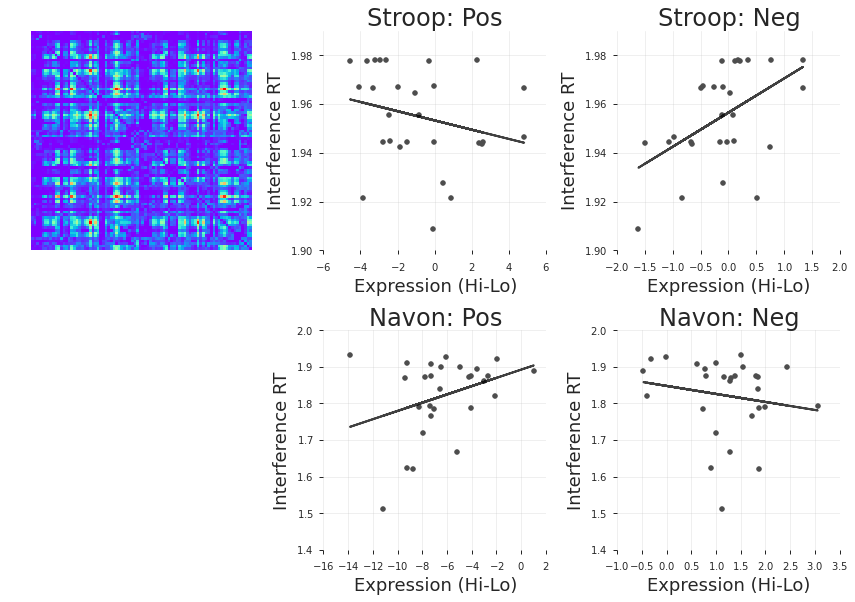





****************************** Subgraph 2 ******************************
    RH_accumbensarea
    LH_accumbensarea
    RH_lateralorbitofrontal
    RH_medialorbitofrontal
    LH_lateralorbitofrontal
    RH_frontalpole

     Stroop: Pos: rho: -0.19743 pval: 0.31393 sig: 
     Stroop: Neg: rho: 0.34808 pval: 0.06950 sig: 
      Navon: Pos: rho: 0.49853 pval: 0.00693 sig: 
      Navon: Neg: rho: -0.13211 pval: 0.50277 sig: 


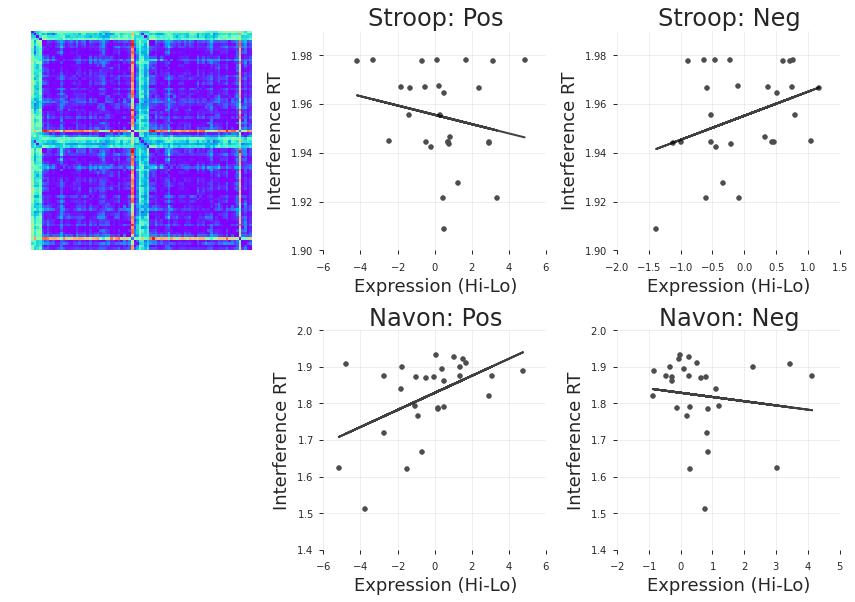





****************************** Subgraph 1 ******************************
    LH_lateraloccipital
    LH_putamen
    RH_hyppocampus
    LH_amygdala
    LH_fusiform
    RH_putamen

     Stroop: Pos: rho: 0.00952 pval: 0.96167 sig: 
     Stroop: Neg: rho: -0.20985 pval: 0.28381 sig: 
      Navon: Pos: rho: -0.29530 pval: 0.12711 sig: 
      Navon: Neg: rho: -0.09420 pval: 0.63350 sig: 


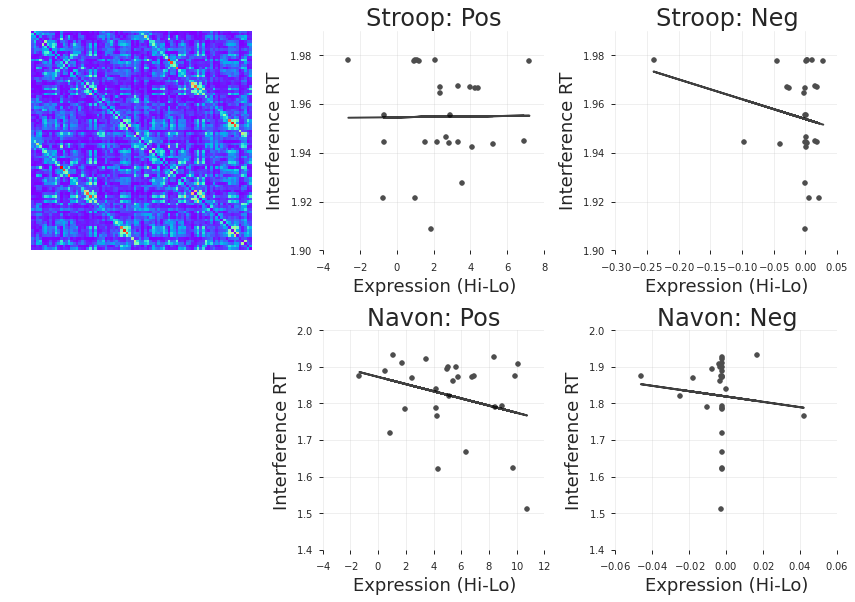





****************************** Subgraph 3 ******************************
    LH_lateraloccipital
    LH_rostralanteriorcingulate
    RH_lateraloccipital
    LH_medialorbitofrontal
    RH_rostralanteriorcingulate
    LH_superiorparietal

     Stroop: Pos: rho: -0.27799 pval: 0.15205 sig: 
     Stroop: Neg: rho: 0.11413 pval: 0.56309 sig: 
      Navon: Pos: rho: 0.13268 pval: 0.50092 sig: 
      Navon: Neg: rho: 0.14205 pval: 0.47088 sig: 


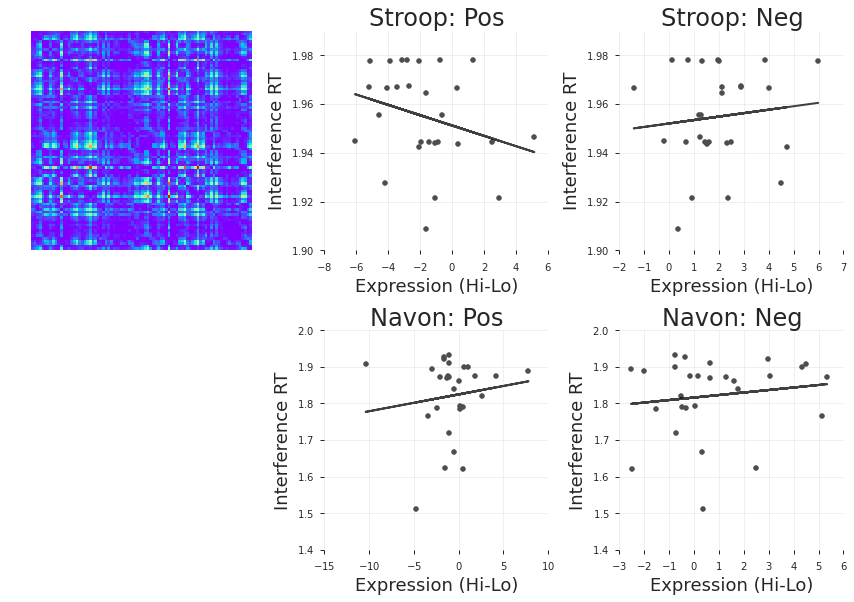





****************************** Subgraph 4 ******************************
    RH_rostralmiddlefrontal
    RH_caudalmiddlefrontal
    RH_parsorbitalis
    RH_inferiorparietal
    RH_middletemporal
    RH_frontalpole

     Stroop: Pos: rho: -0.24003 pval: 0.21859 sig: 
     Stroop: Neg: rho: 0.07464 pval: 0.70584 sig: 
      Navon: Pos: rho: -0.06647 pval: 0.73684 sig: 
      Navon: Neg: rho: 0.14475 pval: 0.46241 sig: 


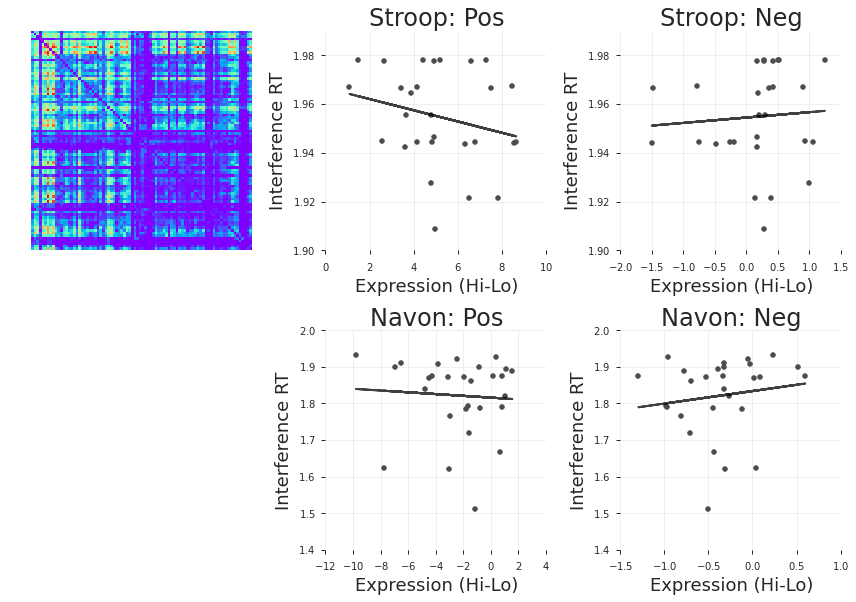

In [12]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Pos': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                      'Neg': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']},
           'Navon' : {'Pos': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
                      'Neg': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Pos', 'Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_acc],
           'Navon': [navon_move, navon_acc]}

#sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]
sel_fac_ix = np.sort(real_ix[high_ix])[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_coef_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_coef_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)            
            mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            

            m, b, rho, pval, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': rho,
                                     'pval': pval,
                                     'slope': m,
                                     "interc": b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi-Lo)')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')